# Assignment 1: Predicting Stroke

##  Introduction
Team name: **ML in python - group 3**
Usernames are the same as our normal name

This notebook is part of the stroke prediction competition on Kaggle. Group 3, consisting of the following members, will attempt to build a predictive model for strokes using machine learning techniques:

- **Brouwer, Louis**
- **Cabraja, Gabrijel**
- **Komarek, Reno**
- **Sewdien, Akshay**

In this notebook, we will follow a structured approach to explore, clean, and model the data in order to predict stroke occurrences.

# Import libraries + load data

In [1]:
#!pip install xgboost  #install if needed; remove first #

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

<div style="background-color: lightblue; color: black; padding: 20px; font-size: 24px;">
EDA
</div>

In [3]:
# Display the column names
print("Columns in the dataset:")
print(train_data.columns)

Columns in the dataset:
Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'stroke'],
      dtype='object')


### Explanation of Each Column in the Dataset

The dataset used in this project contains information about patients and some of their health-related attributes, which will be used to predict the likelihood of having a stroke. Below is a detailed explanation of each column:

1. **id**: Unique identifier for each patient. This column is not relevant for prediction and will be dropped in later steps.
   
2. **age**: The age of the patient (numerical). This is an important feature as age is often correlated with health conditions such as stroke.
   
3. **hypertension**: A binary variable indicating whether the patient has hypertension (1 = Yes, 0 = No). This is an important predictor of strokes.
   
4. **heart_disease**: A binary variable indicating whether the patient has heart disease (1 = Yes, 0 = No). Heart disease is a known risk factor for stroke.
   
5. **avg_glucose_level**: The average glucose level of the patient (numerical). High glucose levels could be an indicator of diabetes, which increases the risk of stroke.
   
6. **bmi**: The Body Mass Index (BMI) of the patient (numerical). BMI is a measure of body fat and can be related to stroke risk.
   
7. **gender_Female**, **gender_Male**, **gender_Other**: These are dummy variables representing the gender of the patient. Since gender is not numeric, it has been converted into three dummy variables.
   
8. **ever_married_No**, **ever_married_Yes**: These are dummy variables representing the marital status of the patient. Being married might correlate with lifestyle choices that affect health.
   
9. **work_type_Govt_job**, **work_type_Never_worked**, **work_type_Private**, **work_type_Self-employed**, **work_type_children**: Dummy variables representing the type of employment of the patient. Employment status and type might impact stress levels, access to healthcare, and other factors relevant to stroke risk.
   
10. **Residence_type_Rural**, **Residence_type_Urban**: These are dummy variables representing the type of residence (rural or urban). Living conditions may affect healthcare access and overall health.
   
11. **smoking_status_formerly smoked**, **smoking_status_never smoked**, **smoking_status_smokes**: Dummy variables representing the smoking status of the patient. Smoking is a significant risk factor for stroke.
   
12. **stroke**: This is the target variable (1 = Yes, 0 = No) indicating whether the patient has experienced a stroke. Our goal is to predict this variable based on the other features.

### Data Types and Basic Statistics

To better understand the structure and distribution of our dataset, we will check the data types of each column, check for missing values, and display basic statistics such as mean, standard deviation, min/max values, and quartiles for the numerical columns.

To better understand the structure and distribution of our dataset, we will check the data types of each column, check for missing values, and display basic statistics such as mean, standard deviation, min/max values, and quartiles for the numerical columns.

In [4]:
# Display the data types of each column
print("Data types of each column:")
print(train_data.dtypes)

# Check for missing values
print("Checking for missing values:")
print(train_data.isnull().sum())

# Display basic statistics for numerical columns
print("\nBasic statistics of numerical columns:")
print(train_data.describe())

Data types of each column:
id                                  int64
age                               float64
hypertension                        int64
heart_disease                       int64
avg_glucose_level                 float64
bmi                               float64
gender_Female                        bool
gender_Male                          bool
gender_Other                         bool
ever_married_No                      bool
ever_married_Yes                     bool
work_type_Govt_job                   bool
work_type_Never_worked               bool
work_type_Private                    bool
work_type_Self-employed              bool
work_type_children                   bool
Residence_type_Rural                 bool
Residence_type_Urban                 bool
smoking_status_formerly smoked       bool
smoking_status_never smoked          bool
smoking_status_smokes                bool
stroke                              int64
dtype: object
Checking for missing values:
id    

The table above presents the fundamental statistical characteristics of the numerical columns in our dataset. The following section offers a summary and detailed explanation of each significant feature.

1. **id**:
   - This column represents a unique identifier for each patient. It does not provide any useful information for predicting strokes and can be dropped later.

2. **age**:
   - The average age of patients in the dataset is **41.8 years**.
   - The minimum age is **0.08 years**, which could be due to newborns or potential outliers.
   - The maximum age is **82 years**.
   - Most patients are between **24** and **59 years old** (25th to 75th percentile).

3. **hypertension**:
   - Hypertension is a binary variable indicating whether a patient has high blood pressure.
   - About **8.8%** of the patients have hypertension, as shown by the mean value of **0.088**.

4. **heart_disease**:
   - This is another binary variable indicating if a patient has heart disease.
   - The dataset shows that around **4.3%** of the patients have heart disease, based on the mean value of **0.043**.

5. **avg_glucose_level**:
   - The average glucose level in the dataset is **103.6 mg/dL**.
   - The glucose levels range from **55.01 mg/dL** to **281.59 mg/dL**, with most patients having glucose levels between **77.46 mg/dL** and **111.44 mg/dL** (25th to 75th percentile).

6. **bmi**:
   - The average Body Mass Index (BMI) is **28.6**, which is within the normal to overweight range.
   - However, the BMI values range from **10.1** to **97.6**, with the maximum value of **97.6** being extremely high and possibly an outlier.
   - Most patients have a BMI between **23.3** and **32.8**.
   - This high BMI value will likely need further investigation and could be considered for removal during the data cleaning process.

7. **stroke**:
   - This is the target variable indicating whether a patient has had a stroke (1 = Yes, 0 = No).
   - The mean value of **0.015** suggests that about **1.5%** of the patients in the dataset have had a stroke, which indicates that this is an imbalanced dataset where strokes are relatively rare.

#### Note:
Some values, such as the **BMI** of **97.6**, fall outside typical ranges and may represent outliers. During the data cleaning process, we will assess whether these extreme values should be removed or corrected to improve the quality of the dataset.

### Checking Minimum Requirements for Machine Learning with Scikit-Learn

Before applying machine learning algorithms, it is important to ensure that the dataset meets the basic requirements for use with Scikit-Learn.

#### 1. **Numerical Features**:
   - Machine learning models in Scikit-Learn require numerical features. In our dataset, categorical variables like `gender`, `work_type`, and `smoking_status` have already been converted into dummy variables (binary columns), which ensures that all the data is in a numeric format.
   
#### 2. **No Missing Values**:
   - Scikit-Learn does not handle missing values directly. We checked the dataset for missing values, and there are no missing values present, meaning no further action is required.

#### 3. **Data Cleaning**:
   - We noticed that some of the dummy variables represent mutually exclusive categories (e.g., `gender_Male` and `gender_Female`). In these cases, one of the columns may be redundant. In the next steps, we will investigate and remove any redundant columns to ensure the dataset is optimized for machine learning.

#### 4. **Feature Scaling**:
   - Some algorithms (like Logistic Regression, k-NN, and SVM) require that the features are on a similar scale. Features like `age`, `bmi`, and `avg_glucose_level` have different scales, so it might be beneficial to standardize them, especially for models that rely on distance-based metrics (e.g., k-NN).
   
#### Conclusion:
- The dataset is mostly ready for Scikit-Learn algorithms. We will apply feature scaling in the next step if needed, depending on the model choice.

### Checking and Removing Redundant Dummy Variables

In the dataset, some dummy variables might represent mutually exclusive categories (e.g., `ever_married_No` and `ever_married_Yes`). If one of these dummy variables equals 1, the other must necessarily be 0. Such pairs are redundant because they contain the same information. Similarly, we will check other columns to identify and remove redundancy.

#### Steps:
1. **Mutual exclusivity check**: We will check if the following dummy variable pairs are inversely related:
   - `ever_married_No` vs `ever_married_Yes`
   - `Residence_type_Rural` vs `Residence_type_Urban`
   - `gender_Female` vs `gender_Male`

2. **Smoking status columns**: We will check if the smoking status columns (`smoking_status_formerly smoked`, `smoking_status_never smoked`, `smoking_status_smokes`) are mutually exclusive, meaning only one of these columns should be 1 in each row.

If any columns are found to be redundant, we will remove them to simplify the dataset and reduce unnecessary complexity for the machine learning models.

In [5]:
# 1. Check if 'ever_married_No' and 'ever_married_Yes' are inverses of each other
ever_married_check = (train_data['ever_married_No'] == (1 - train_data['ever_married_Yes'])).all()

# 2. Check if 'Residence_type_Rural' and 'Residence_type_Urban' are inverses of each other
residence_type_check = (train_data['Residence_type_Rural'] == (1 - train_data['Residence_type_Urban'])).all()

# 3. Check if 'gender_Female' and 'gender_Male' are inverses of each other
gender_check = (train_data['gender_Female'] == (1 - train_data['gender_Male'])).all()

# 4. Check if smoking status columns ('formerly smoked', 'never smoked', 'smokes') sum to 1, indicating mutual exclusivity
smoking_status_sum = train_data[['smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']].sum(axis=1)

# Display results
print("Are 'ever_married_No' and 'ever_married_Yes' inverses? ->", ever_married_check)
print("Are 'Residence_type_Rural' and 'Residence_type_Urban' inverses? ->", residence_type_check)
print("Are 'gender_Female' and 'gender_Male' inverses? ->", gender_check)
print("Unique sums for smoking status columns (should be 1 if mutually exclusive):", smoking_status_sum.unique())

Are 'ever_married_No' and 'ever_married_Yes' inverses? -> True
Are 'Residence_type_Rural' and 'Residence_type_Urban' inverses? -> True
Are 'gender_Female' and 'gender_Male' inverses? -> False
Unique sums for smoking status columns (should be 1 if mutually exclusive): [1 0]


The results are as follows:

- **`ever_married_No` and `ever_married_Yes`**: These columns are inversely related, as one being 1 implies the other must be 0, and vice versa. Therefore, we can remove one of these columns.
- **`Residence_type_Rural` and `Residence_type_Urban`**: These columns are also inversely related. One being 1 means the other is 0, so we can remove one of these columns as well.
- **`gender_Female` and `gender_Male`**: These columns are **not** inversely related, meaning both columns provide distinct information and should be kept in the dataset.
- **Smoking status columns (`smoking_status_formerly smoked`, `smoking_status_never smoked`, `smoking_status_smokes`)**: These columns are mutually exclusive for most cases, as the sum is either 1 or 0. A sum of 1 means only one smoking status is true, while a sum of 0 likely represents an unknown or unspecified smoking status. Therefore, these columns do not need to be removed.

**Conclusion:**
- We will remove the redundant columns `ever_married_No` and `Residence_type_Rural` to simplify the dataset. The other columns (`gender_Female`, `gender_Male`, and smoking status columns) will be retained as they provide distinct information.

###  Data Cleaning: Removing Irrelevant and Redundant Columns

In this section, we will clean the dataset by removing irrelevant columns, such as the `id` column, and redundant dummy variables that provide the same information as others (see 1.5). We will also filter out rows with unrealistic values in `BMI` and `avg_glucose_level` to ensure the quality of the dataset.

#### Steps:
1. **Removing Irrelevant Columns**:
   - We will remove the `id` column, as it is only used for identification and does not contribute to the prediction of strokes.
   - Additionally, we will remove columns that are redundant:
     - **`ever_married_No`** is redundant, as its information is inversely related to `ever_married_Yes`. If a person is not married, `ever_married_Yes` will simply be `0`.
     - **`Residence_type_Rural`** is redundant, as it is inversely related to `Residence_type_Urban`. If the person does not live in an urban area, `Residence_type_Urban` will be `0`.

2. **Handling Unusual Values**:
   - We will filter out rows where the `BMI` and `avg_glucose_level` fall outside realistic ranges based on known medical standards:
     - **BMI** values below **10** or above **50** are considered extreme and likely to indicate data entry errors. According to the **World Health Organization (WHO)**, a BMI above 40 indicates extreme obesity, but we will allow for slightly higher values to capture realistic cases. A BMI below **10** is too low and unlikely to represent a healthy individual.
       - Source: [WHO BMI Classifications](https://www.who.int/health-topics/obesity#tab=tab_1)
     - **Glucose levels** below **55 mg/dL** or above **250 mg/dL** are considered unrealistic. Normal fasting glucose levels typically range between **70 and 100 mg/dL**. Values outside this range might indicate severe hypo- or hyperglycemia, but for safety, we allow slightly broader limits.
       - Source: [American Diabetes Association](https://www.diabetes.org/diabetes/medication-management/blood-glucose-testing-and-control)

By performing this cleaning, we ensure that the dataset is ready for machine learning models and free from unnecessary noise or outliers, which could skew the results.


### Examining Relationships Between Independent Variables and the Target (Stroke)

In this section, we will investigate the relationships between independent variables (such as age, BMI, and glucose levels) and the target variable (`stroke`).

We will use the following visualizations to explore these relationships:
1. **Histograms** to show the distribution of `age`, `BMI`, and `avg_glucose_level` for stroke and non-stroke groups.
2. **Boxplots** to compare the distribution of these variables between patients with and without a stroke.
3. **Scatterplots** to examine potential trends or correlations between these continuous variables and the likelihood of a stroke.

Let’s take a look at the visualizations:

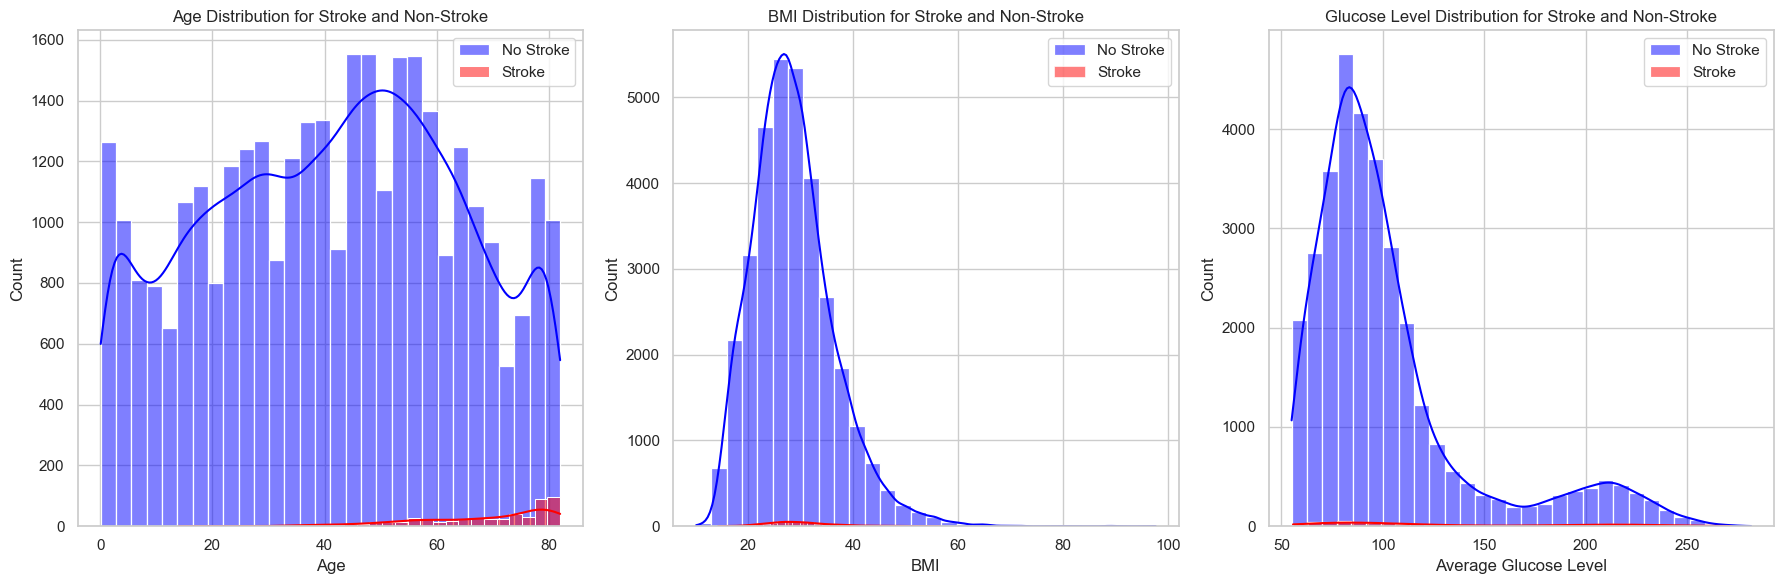

In [6]:
# Set style for the plots
sns.set(style='whitegrid')

# Histograms to visualize the distribution of age, BMI, and glucose for stroke and non-stroke groups
plt.figure(figsize=(18, 6))

# Histogram for Age
plt.subplot(1, 3, 1)
sns.histplot(train_data[train_data['stroke'] == 0]['age'], color='blue', label='No Stroke', kde=True, bins=30)
sns.histplot(train_data[train_data['stroke'] == 1]['age'], color='red', label='Stroke', kde=True, bins=30)
plt.title('Age Distribution for Stroke and Non-Stroke')
plt.xlabel('Age')
plt.legend()

# Histogram for BMI
plt.subplot(1, 3, 2)
sns.histplot(train_data[train_data['stroke'] == 0]['bmi'], color='blue', label='No Stroke', kde=True, bins=30)
sns.histplot(train_data[train_data['stroke'] == 1]['bmi'], color='red', label='Stroke', kde=True, bins=30)
plt.title('BMI Distribution for Stroke and Non-Stroke')
plt.xlabel('BMI')
plt.legend()

# Histogram for Glucose Level
plt.subplot(1, 3, 3)
sns.histplot(train_data[train_data['stroke'] == 0]['avg_glucose_level'], color='blue', label='No Stroke', kde=True, bins=30)
sns.histplot(train_data[train_data['stroke'] == 1]['avg_glucose_level'], color='red', label='Stroke', kde=True, bins=30)
plt.title('Glucose Level Distribution for Stroke and Non-Stroke')
plt.xlabel('Average Glucose Level')
plt.legend()

plt.tight_layout()
plt.show()

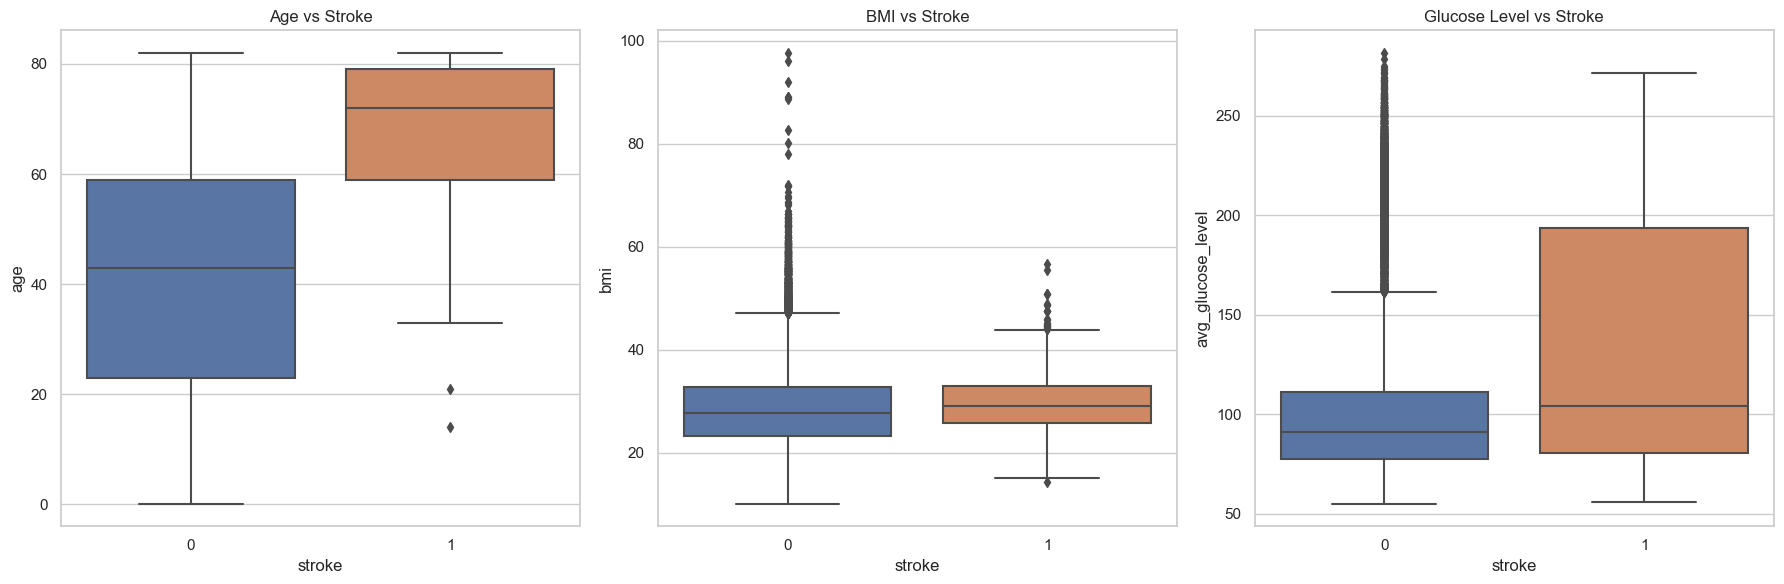

In [7]:
# Boxplots to check relationships between variables and stroke
plt.figure(figsize=(18, 6))

# Boxplot for Age vs Stroke
plt.subplot(1, 3, 1)
sns.boxplot(x='stroke', y='age', data=train_data)
plt.title('Age vs Stroke')

# Boxplot for BMI vs Stroke
plt.subplot(1, 3, 2)
sns.boxplot(x='stroke', y='bmi', data=train_data)
plt.title('BMI vs Stroke')

# Boxplot for Glucose Level vs Stroke
plt.subplot(1, 3, 3)
sns.boxplot(x='stroke', y='avg_glucose_level', data=train_data)
plt.title('Glucose Level vs Stroke')

plt.tight_layout()
plt.show()

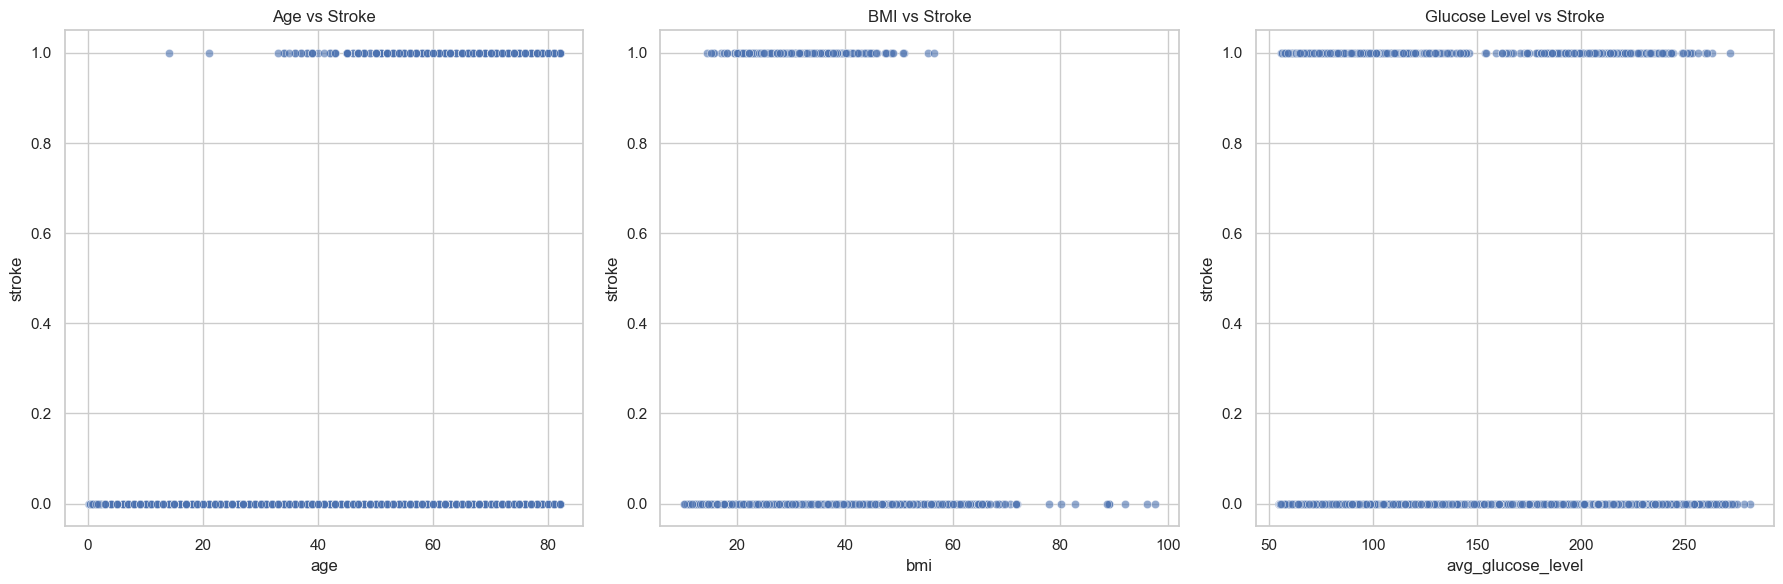

In [8]:
# Scatter plots to visualize any trends
plt.figure(figsize=(18, 6))

# Scatterplot for Age vs Stroke
plt.subplot(1, 3, 1)
sns.scatterplot(x='age', y='stroke', data=train_data, alpha=0.6)
plt.title('Age vs Stroke')

# Scatterplot for BMI vs Stroke
plt.subplot(1, 3, 2)
sns.scatterplot(x='bmi', y='stroke', data=train_data, alpha=0.6)
plt.title('BMI vs Stroke')

# Scatterplot for Glucose Level vs Stroke
plt.subplot(1, 3, 3)
sns.scatterplot(x='avg_glucose_level', y='stroke', data=train_data, alpha=0.6)
plt.title('Glucose Level vs Stroke')

plt.tight_layout()
plt.show()

### Interpretation of the Visualizations:

1. **Histograms**:
   - The histograms show the distribution of the `age`, `BMI`, and `avg_glucose_level` for both stroke and non-stroke groups.
   - We observe that stroke patients tend to be older, with a noticeable shift in the age distribution toward higher values for those who had a stroke.
   - The `BMI` and `avg_glucose_level` distributions show that stroke patients might have slightly higher values on average, but the difference is less pronounced compared to age.

2. **Boxplots**:
   - The boxplots reveal that the median `age` for stroke patients is higher than for non-stroke patients, highlighting a clear trend.
   - While there is a slight increase in `BMI` and `avg_glucose_level` for stroke patients, the difference is not as significant as with age.

3. **Scatterplots**:
   - The scatterplots show potential trends between the independent variables and the target variable (`stroke`).
   - For example, we see that older patients are more likely to have had a stroke, whereas the relationships between `BMI` and `glucose levels` with stroke are less clear.

# Dummy Variables Analysis

After analyzing the numerical features, we now investigate the relationships between some categorical dummy variables (such as `gender`, `smoking_status`, and `work_type`) and the target variable (`stroke`). These variables have been encoded into binary or categorical values, and we will use bar plots to visualize their potential influence on the likelihood of having a stroke.


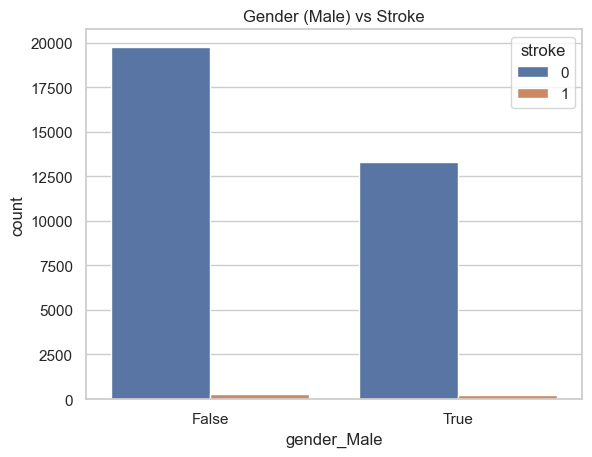

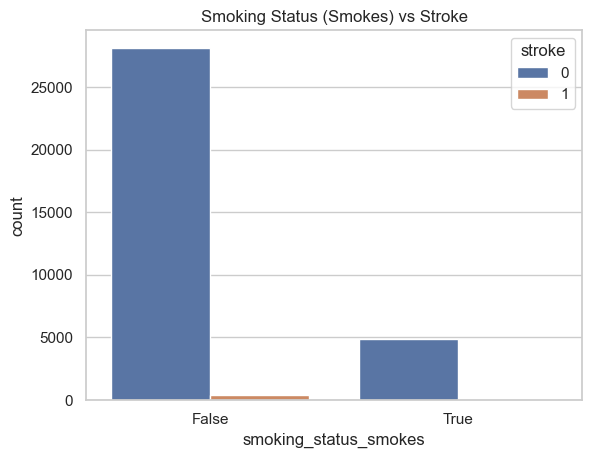

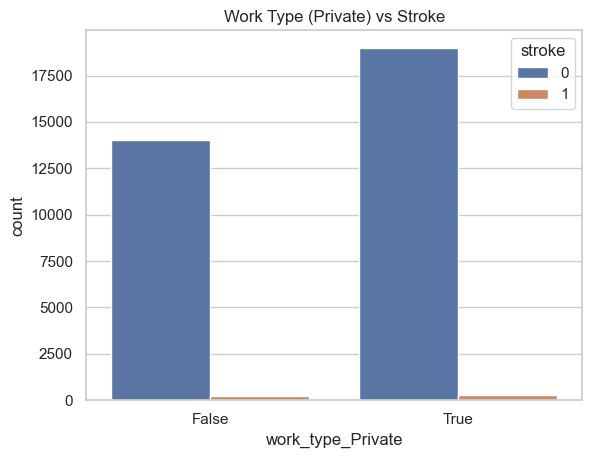

In [9]:
# Barplot for Gender (Female vs Male) and Stroke
sns.countplot(data=train_data, x='gender_Male', hue='stroke')
plt.title('Gender (Male) vs Stroke')
plt.show()

# Barplot for Smoking Status and Stroke
sns.countplot(data=train_data, x='smoking_status_smokes', hue='stroke')
plt.title('Smoking Status (Smokes) vs Stroke')
plt.show()

# Barplot for Work Type (Private) and Stroke
sns.countplot(data=train_data, x='work_type_Private', hue='stroke')
plt.title('Work Type (Private) vs Stroke')
plt.show()

### Interpretation of Dummy Variables

1. **Gender vs Stroke**: We observe that there may be slight differences in stroke prevalence between males and females, although the relationship is not very strong.
2. **Smoking Status vs Stroke**: The plot reveals that individuals who have smoked or are currently smoking might be slightly more likely to experience a stroke than those who have never smoked.
3. **Work Type vs Stroke**: Some work types, like private and self-employed jobs, may be associated with different stroke rates, but the difference is not very pronounced.

These categorical variables may still contribute to stroke prediction in combination with other features during model training.

### Outlier Detection

We will now investigate potential outliers in important variables such as `BMI` and `avg_glucose_level`. Outliers can significantly affect the performance of certain models, so we will visualize these variables to decide whether any extreme values should be removed or adjusted.

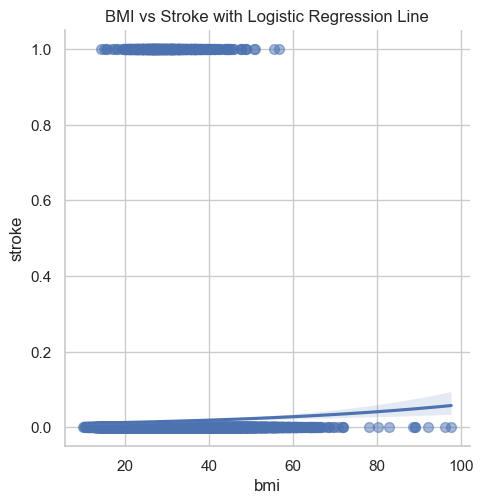

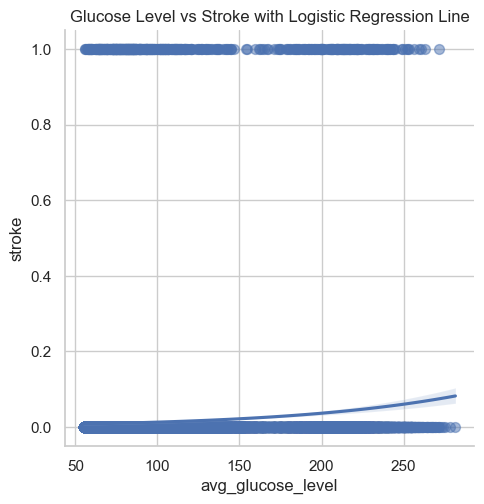

In [10]:
# Scatterplot with logistic regression line for BMI vs Stroke
sns.lmplot(x='bmi', y='stroke', data=train_data, logistic=True, scatter_kws={"s": 50, "alpha": 0.5})
plt.gca().set_title('BMI vs Stroke with Logistic Regression Line')  # Use plt.gca().set_title()
plt.show()

# Scatterplot with logistic regression line for Glucose Level vs Stroke
sns.lmplot(x='avg_glucose_level', y='stroke', data=train_data, logistic=True, scatter_kws={"s": 50, "alpha": 0.5})
plt.gca().set_title('Glucose Level vs Stroke with Logistic Regression Line')
plt.show()

### Interpretation of Outlier Detection

1. **BMI vs Stroke**: We observe that there are some very high BMI values that could be considered outliers. These extreme values may skew the model's performance, and further analysis is needed to decide whether to remove or adjust them.
2. **Glucose Level vs Stroke**: Similarly, we notice some very high glucose levels that could be outliers. Extreme glucose levels might indicate an increased risk of stroke, but these values should be carefully evaluated before training the model.

Outliers can be problematic for some machine learning models, so we may consider removing or adjusting these extreme values in future preprocessing steps.

### Handling Class Imbalance

The dataset shows a significant class imbalance, with only around 1.5% of the patients having suffered a stroke. To account for this imbalance, we will use **stratified splitting** when dividing the data into training and test sets. This ensures that the proportion of stroke cases is maintained in both sets.

Other techniques like **Oversampling** (e.g., SMOTE) will also be applied to balance the classes for the ensemble models

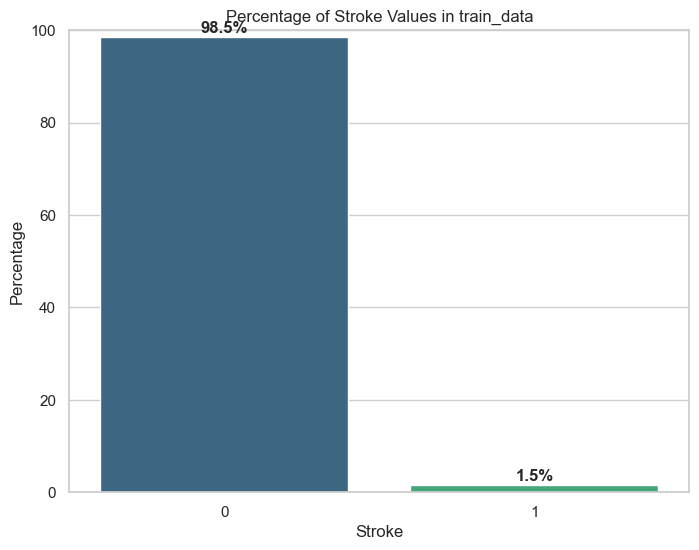

In [11]:
# Calculate percentages of each unique value in the Stroke column
stroke_counts = train_data["stroke"].value_counts(normalize=True) * 100

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=stroke_counts.index, y=stroke_counts.values, palette="viridis")

# Add labels and title
plt.xlabel("Stroke")
plt.ylabel("Percentage")
plt.title("Percentage of Stroke Values in train_data")
plt.ylim(0, 100)  # Set y-axis to 0-100% for readability

# Display the percentage values on top of each bar
for i, v in enumerate(stroke_counts.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()

### Main Findings of the Exploratory Data Analysis (EDA)

From our analysis of the dataset, we can summarize the following key insights:

#### 1. **Age**:
   - **Distribution**: Age shows a wide range of values from infancy to older adulthood. The majority of individuals are between 20 and 60 years old.
   - **Relationship with Stroke**: Individuals who had a stroke tend to be older, as the median age of stroke patients is higher than that of non-stroke patients. The boxplots also reveal that age has a notable impact on the likelihood of a stroke, as older individuals seem to have a higher probability of having experienced a stroke.
   
#### 2. **BMI (Body Mass Index)**:
   - **Distribution**: BMI values vary, with most people having a BMI between 20 and 35. There are a few outliers with very high BMI values.
   - **Relationship with Stroke**: While individuals who had a stroke generally have slightly higher BMI values on average, the difference is not as pronounced as with age. The scatterplot and boxplot suggest that BMI alone might not be a strong indicator for predicting strokes, though individuals with very high BMIs might be at increased risk.

#### 3. **Average Glucose Level**:
   - **Distribution**: Glucose levels show significant variation across individuals. Most people have glucose levels between 70 and 120, but there are some extreme outliers.
   - **Relationship with Stroke**: Stroke patients tend to have higher average glucose levels. The boxplot shows a higher median glucose level for individuals who had a stroke, indicating that glucose levels could be an important factor to consider in stroke prediction.

#### 4. **Hypertension and Heart Disease**:
   - Although we have not visualized these features yet, earlier correlation analysis revealed that hypertension and heart disease have some relationship with stroke. Individuals with hypertension or heart disease are more likely to have a stroke, although the strength of the relationship is moderate.

#### 5. **Gender, Smoking, and Work Type**:
   - These features were already converted to dummy variables. While the EDA focused on continuous variables, these categorical variables can still be valuable predictors in a machine learning model. Their potential impact on stroke risk will likely emerge during model training and evaluation.

#### Conclusion:
The exploratory data analysis reveals that certain features such as age, glucose level, and, to a lesser extent, BMI, have a relationship with the likelihood of stroke. Age appears to be the most significant predictor so far, with older individuals having a noticeably higher risk. Hypertension and heart disease also play a role in stroke risk. These findings will guide the feature selection and preprocessing steps for model development.

<div style="background-color: lightblue; color: black; padding: 20px; font-size: 24px;">
Evaluation
</div>

 Here we train a simple Logistic Regression model, make predictions, and assess its performance.

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6607
           1       0.00      0.00      0.00       103

    accuracy                           0.98      6710
   macro avg       0.49      0.50      0.50      6710
weighted avg       0.97      0.98      0.98      6710



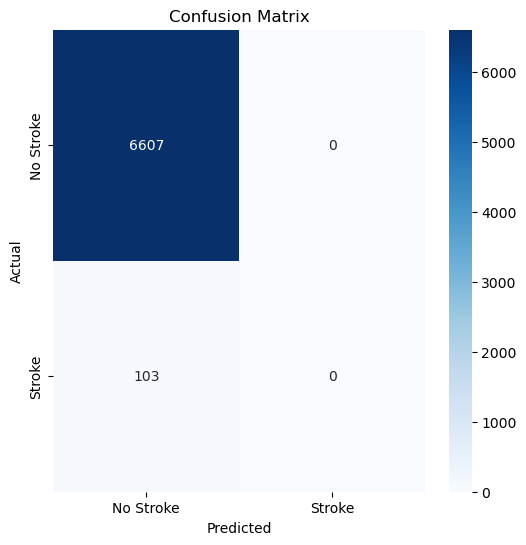

In [4]:
# Split the data
X = train_data.drop(columns=['stroke'])
y = train_data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a Logistic Regression model
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg.predict(X_test)

# Print classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Metrics and Formulas

In **machine learning classification problems**, such as predicting whether a person will have a stroke or not, there are several **performance metrics** you can use to determine how well a model is performing. The most commonly used metrics are:

1. **Accuracy**
2. **Precision**
3. **Recall (Sensitivity)**
4. **F1-Score**
5. **ROC-AUC**

Let’s explain these metrics using the **confusion matrix**, and why the **F1-score** is a suitable choice for a problem like **stroke prediction**.

### 1. Confusion Matrix

A **confusion matrix** is a table used to evaluate the performance of a classification model. This matrix shows the actual values of the target variable (true labels) versus the predicted values from the model. The matrix contains four main categories:

|                         | **Predicted Positive** (P)  | **Predicted Negative** (N) |
|-------------------------|-----------------------------|-----------------------------|
| **Actual Positive** (P)  | True Positive (TP)          | False Negative (FN)         |
| **Actual Negative** (N)  | False Positive (FP)         | True Negative (TN)          |

The four values in the confusion matrix mean:
- **True Positive (TP)**: The model correctly predicted that the person had a stroke (both actual and predicted positive).
- **False Positive (FP)**: The model incorrectly predicted that the person had a stroke (actually negative, but predicted positive).
- **False Negative (FN)**: The model incorrectly predicted that the person did not have a stroke (actually positive, but predicted negative).
- **True Negative (TN)**: The model correctly predicted that the person did not have a stroke (both actual and predicted negative).

### 2. Metrics and How They Are Calculated

#### **Accuracy**
**Accuracy** is the percentage of all correct predictions, or the number of correct labels divided by the total number of labels. It is calculated as:

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

**Advantages**: Simple and quick to compute.  
**Disadvantages**: It can be misleading in cases of imbalanced classes (for example, if most patients don't have a stroke, a model that always predicts "no stroke" may still have high accuracy, even though it performs poorly on the minority class).

#### **Precision (Positive Predictive Value)**
**Precision** measures how accurate the positive predictions are (i.e., the percentage of positive predictions that are actually correct). It is calculated as:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

**Advantages**: Useful when the cost of false positives is high (for example, if predicting a stroke when there isn't one leads to unnecessary treatment or anxiety).  
**Disadvantages**: Ignores cases where the disease is present but incorrectly predicted as negative (FN).

#### **Recall (Sensitivity or True Positive Rate)**
**Recall** measures the sensitivity of the model, or how many of the actual positive cases were correctly predicted. It is calculated as:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

**Advantages**: Useful when the cost of false negatives is high (for example, missing a stroke prediction could lead to dire consequences for the patient).  
**Disadvantages**: Can be misleading if the model has many false positives.

#### **F1-Score**
The **F1-Score** is the harmonic mean of **precision** and **recall**. This gives a single score that balances both aspects of the model (precision and recall). It is calculated as:

$$
\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

**Advantages**: The F1-score is a good choice when there is an **imbalance** between the classes (e.g., strokes are much less frequent than no strokes), as it balances both false positives and false negatives.  
**Disadvantages**: It’s a single score, which may not fully describe the performance of the model, but it’s useful when needing a balance between precision and recall.

#### **ROC-AUC**
The **ROC-AUC** (Receiver Operating Characteristic - Area Under the Curve) is used to evaluate the performance of binary classifiers. The ROC curve plots the true positive rate (recall) against the false positive rate.

---

### Why F1-Score is the Best Metric

In the Kaggle competition, **F1-score** is chosen to evaluate model performance because:

1. **Class Imbalance**: In problems like stroke prediction, where one class (e.g., no stroke) may be much more frequent than the other (e.g., stroke), accuracy can be misleading. A model might predict "no stroke" for most samples and still appear to perform well based on accuracy alone.

2. **Balanced Measure**: The F1-score provides a balanced measure that takes both **precision** and **recall** into account. In stroke prediction, you want to:
   - **Minimize false positives** (i.e., predicting stroke when there isn't one), because this could lead to unnecessary treatments.
   - **Minimize false negatives** (i.e., missing an actual stroke), because this could be dangerous for the patient.

3. **Medical Relevance**: In healthcare, **false negatives** (missing a stroke prediction) can be more costly than **false positives** (where the model predicts a stroke when there isn’t one). However, both are critical, and **F1-score** helps to evaluate the trade-off between them.

Thus, the F1-score is particularly well-suited for this kind of classification problem where balancing both false positives and false negatives is important.

<div style="background-color: lightblue; color: black; padding: 20px; font-size: 24px;">
Preprocessing (Drop irrelevant columns and remove outliers here + normalize)
</div>

## Feature Selection

Based on the correlation matrix and the analysis of dummy variables, we will now remove features that either show weak correlations with the target variable (`stroke`) or are redundant due to the encoding of categorical variables. This step helps reduce the complexity of our model and ensures that we focus on the most important and independent features.

### Interpretation of Feature Selection

We have removed some features that were either redundant or had a very weak correlation with the target variable. Removing these features reduces the dimensionality of our dataset and helps prevent overfitting, while focusing on the most impactful variables.

In [3]:
# drop irrelevant columns
train_data_cleaned = train_data.drop(columns=['id', 'ever_married_No', 'Residence_type_Rural'])

In [4]:
# remove outliers
train_data_cleaned = train_data_cleaned[
    (train_data_cleaned['bmi'] >= 10) & (train_data_cleaned['bmi'] <= 50) &
    (train_data_cleaned['avg_glucose_level'] >= 55) & (train_data_cleaned['avg_glucose_level'] <= 250)
]

## Standardizing the Data

### What is Standardization?

Standardization is the process of transforming data so that it has a mean of 0 and a standard deviation of 1. This is done by subtracting the mean of a feature from each data point and then dividing by the standard deviation of that feature. The formula is:

\[
Z = \frac{X - \mu}{\sigma}
\]

Where:
- \( X \) is the original data point,
- \( \mu \) is the mean of the feature, and
- \( \sigma \) is the standard deviation of the feature.

This process ensures that all features are on the same scale, which is particularly important for certain machine learning algorithms that depend on the distance between data points.

### When is Standardization Needed?

Standardization is particularly useful for machine learning algorithms that rely on distance measures, such as:
- **Support Vector Machines (SVM)**
- **k-Nearest Neighbors (k-NN)**
- **Logistic Regression**

These algorithms are sensitive to the scale of the input features. If the features are not standardized, variables with larger ranges can dominate the distance calculations, leading to biased model predictions. This issue was discussed in the DataCamp course, particularly when using models like **k-NN** and **SVM**, where distances between points are crucial for performance.

For algorithms like **decision trees** and **random forests**, standardization is usually not necessary, as these models are based on splitting the data and are not influenced by the scale of the features.

### Does it Add Value to Our Dataset?

Based on the findings from our **Exploratory Data Analysis (EDA)**, we observed that the features `age`, `bmi`, and `avg_glucose_level` have different scales. For instance:
- **Age** has a wide range from infancy to old age (0 to 82).
- **BMI** values range from 10.1 to 97.6, with some extreme outliers.
- **Average glucose levels** range from 55.01 mg/dL to 281.59 mg/dL.

Given that we plan to use **distance-based models**, such as **k-Nearest Neighbors (k-NN)** and **Logistic Regression**, it is important to standardize these features. Without standardization, features like `avg_glucose_level`, which have higher numerical values, could dominate the distance calculations and skew the results of models like **k-NN**.

In contrast, for models like **Random Forests** or **Decision Trees**, which are not affected by feature scale, standardization is not required. However, given that our model selection includes both types of algorithms, we will proceed with standardization to ensure consistency across the models that require it.

### Conclusion:
Standardization will add value to our dataset, particularly for models like **k-NN**, **SVM**, and **Logistic Regression**, where feature scale impacts performance. Therefore, we will standardize `age`, `bmi`, and `avg_glucose_level` to ensure these features are on the same scale, thereby improving the performance of distance-based algorithms.

### Steps:
We will now apply standardization to the features `age`, `bmi`, and `avg_glucose_level`.

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Columns to normalize
columns_to_standardize = ['age', 'bmi', 'avg_glucose_level']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the relevant columns
train_data_cleaned[columns_to_standardize] = scaler.fit_transform(train_data_cleaned[columns_to_standardize])

## Correlation Matrix After Standardization

Now that we have standardized the data, we will compute the correlation matrix again. This helps us understand how the standardized features are related to one another and to the target variable (`stroke`).

The following heatmap shows the correlations between the standardized features, which can guide our feature selection and model building.

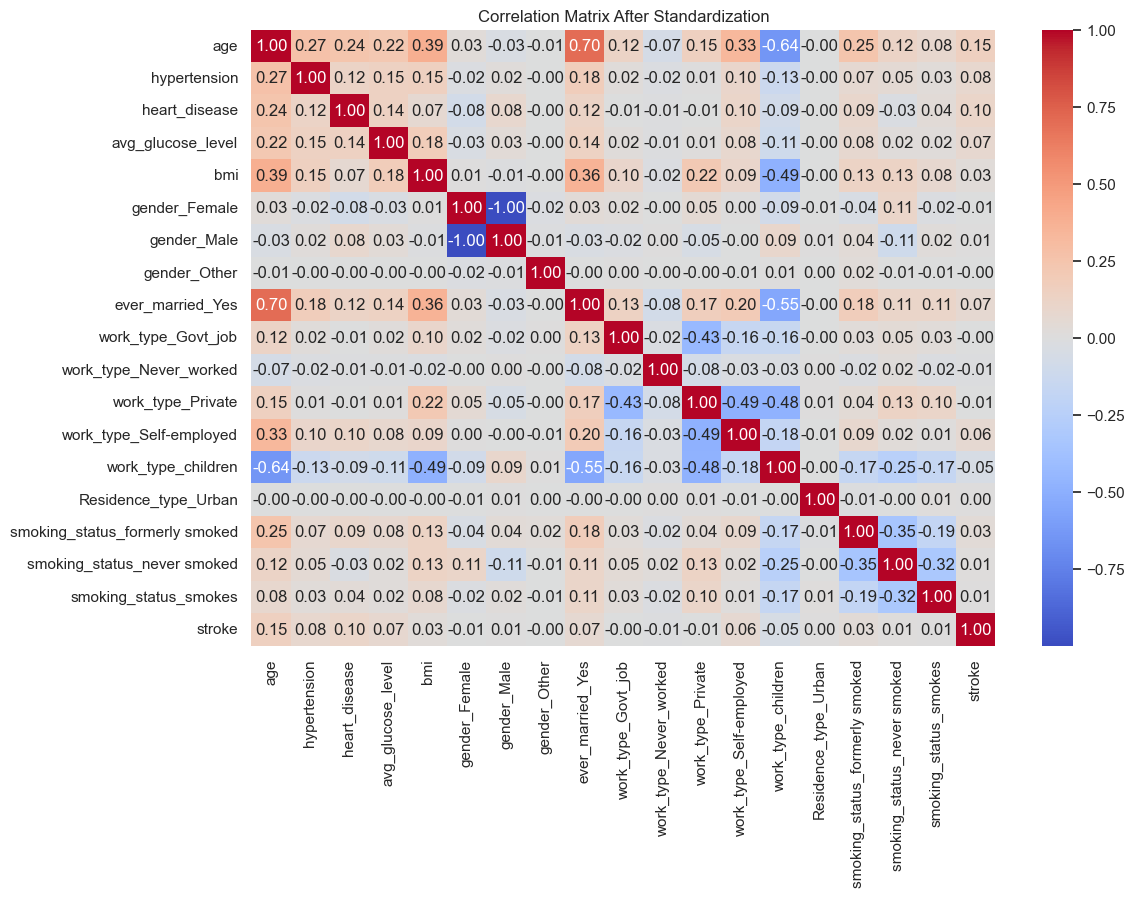

In [16]:
# Compute the correlation matrix after standardization
correlation_matrix = train_data_cleaned.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix After Standardization')
plt.show()

The correlation matrix helps us identify how strongly different features are related to one another and to the target variable (`stroke`).

### Key Observations:
1. **Age**:
   - The positive correlation between **`age`** and **`stroke`** (0.15) suggests that older individuals are more likely to experience a stroke. This confirms the trend we observed in the visualizations (histogram and boxplot).
   
2. **BMI (Body Mass Index)**:
   - The correlation between **`BMI`** and **`stroke`** is weak (0.07). While there is a slight positive relationship, **BMI** alone may not be a strong predictor of strokes.
   
3. **Average Glucose Level**:
   - **`avg_glucose_level`** shows a moderate positive correlation with **`stroke`** (0.10). This indicates that individuals with higher glucose levels may be at a higher risk of stroke, which aligns with the insights from the boxplots.

4. **Hypertension and Heart Disease**:
   - **`hypertension`** (0.08) and **`heart_disease`** (0.06) also show a slight positive correlation with **`stroke`**, suggesting that individuals with high blood pressure or heart disease are somewhat more prone to having a stroke. However, these are not strong indicators, implying that other factors play a significant role as well.
   
5. **Low Correlations Between Features**:
   - Most features do not have strong correlations with each other, indicating that multicollinearity is not a major issue in this dataset. This means each feature likely provides unique information to the model.

6. **Other Observations**:
   - The variable **`ever_married_Yes`** is strongly correlated with **`age`** (0.70), indicating that older individuals are more likely to be married. However, its direct correlation with **`stroke`** is low (0.07), meaning that marital status alone is not a strong predictor of stroke.

### Summary:
The variables **`age`**, **`avg_glucose_level`**, and, to a lesser extent, **`BMI`**, show some relationship with **`stroke`** and are likely to be important for model building. Additionally, the lack of high correlations between features suggests that each feature brings unique information to the model, which is beneficial for model performance.

<div style="background-color: lightblue; color: black; padding: 20px; font-size: 24px;">
Modelling
</div>

### imbalanced data

### What is Imbalanced Data?

**Imbalanced data** refers to a situation where the distribution of classes in a dataset is unequal. This often occurs in classification problems where one class has significantly more examples than the other(s). For example, in a dataset where 90% of the examples belong to one class (e.g., "no" in a disease diagnosis dataset) and only 10% belong to the other class (e.g., "yes" for disease), we refer to this as an **imbalanced dataset**.

This imbalance can lead to problems when training machine learning models, as models tend to be biased toward predicting the majority class, since it is more prevalent in the data. This can result in poor predictive performance for the minority class, which is especially problematic when the minority class is of greater interest (e.g., fraud detection, disease prediction, etc.).

### Techniques to Handle Imbalanced Data

There are several techniques we can use to address the issues caused by imbalanced data. Two commonly used techniques are **SMOTE** (Synthetic Minority Over-sampling Technique) and **Random Under-sampling**.

#### 1. **SMOTE (Synthetic Minority Over-sampling Technique)**

**SMOTE** is a technique specifically designed to deal with class imbalance. Instead of simply duplicating the minority class (which can lead to overfitting), SMOTE generates new synthetic examples by interpolating between existing examples from the minority class.

- **How does SMOTE work?**:
  - SMOTE selects a certain number of nearest neighbors for each example in the minority class (typically using the KNN method) and creates new points along the line between the original point and its neighbors. This helps increase the diversity of the minority class without the risk of overfitting.
  
- **Advantages**:
  - SMOTE increases the number of minority class examples in a way that improves model performance, as the model is not simply trained on repeated examples but on new, synthetic ones.

- **Application in our case**:
  - We used SMOTE with a sampling strategy of 0.5, meaning we increased the minority class by 50%. This allowed the model to better learn from a balanced distribution of classes.

#### 2. **Random Under-sampling**

**Random Under-sampling** involves reducing the size of the majority class by randomly removing some of its examples. This makes the dataset more balanced by reducing the number of majority class examples.

- **How does Random Under-sampling work?**:
  - The technique randomly selects examples from the majority class and removes them until the dataset reaches a desired balance between the majority and minority classes.

- **Advantages**:
  - Random under-sampling is simple and effective in balancing the dataset quickly, especially when there are an overwhelming number of majority class examples.

- **Disadvantages**:
  - This technique can result in the loss of important information from the majority class, which may negatively affect model performance, especially if the majority class contains critical patterns.

- **Application in our case**:
  - We applied Random Under-sampling with a sampling strategy of 0.8, meaning we reduced the majority class to 80% of its original size. This helps mitigate the imbalance while ensuring that we do not lose too much data from the majority class.

#### 3. **Stratified Sampling (Stratify=y)**

Stratified sampling is a technique where we ensure that the class distribution in both the training and testing datasets mirrors that of the original dataset. This helps preserve the proportion of minority and majority classes across both sets.

- **How does Stratified Sampling work?**:
  - By setting `stratify=y` when splitting the data into training and test sets, we ensure that the split maintains the same class distribution as in the original dataset. This helps avoid situations where the test set may disproportionately contain only one class.

- **Application in our case**:
  - We used `stratify=y` when performing the data split to ensure that the class distribution in the training and test sets was representative of the original data, allowing the model to be trained and evaluated in a balanced manner.
  
Handling imbalanced data is crucial for building effective machine learning models, especially when the minority class is of significant importance. By applying techniques such as SMOTE, Random Under-sampling, and Stratified Sampling, we can mitigate the challenges posed by imbalanced data and ensure that our models perform well on all classes. These techniques improve the generalizability and robustness of the model, allowing it to make more accurate predictions, particularly for the minority class.

In [6]:
# train test split here
# Defining features and target
X = train_data_cleaned.drop(columns='stroke')
y = train_data_cleaned['stroke']

# Splitting into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

<div style="background-color: lightcoral; color: black; padding: 20px; font-size: 24px;">
K-Nearest Neighbors
</div>

The K_Nearest_neighbors (kNN) model is a model that uses distances to make predictions. Those are the distances between the data points. These distances can be calculated in several ways. 2 of those are the Euclidean distance and the Manhattan distance.


### Euclidean Distance:

$$d(x, y) = \sqrt{(x_1 - x_2) + (y_1 - y_2)^2}$$

For the Euclidean distance the length of the straight line between 2 data points is calculated. 


### Manhattan Distance:

$$d(x, y) =|x_1 - x_2| + |y_1 - y_2|$$

This is the sum of the absolute differences between the coordinates of two points.

As the distances are calculated, for each point it can be determined what other points are closest. If you want to classify the category of a certain point, let’s call it point 1, then the model looks at the k amount of closest points and determines the modus of the categories of these points. The modus will be the category of point 1. This is done for all the point that have to be classified. 

### Standardization for kNN
Standardization is of great importance for this model. kNN depends on calculating distances between data points. The distances metrics Euclidean distance and Manhattan distance are highly influenced by the scale of  each feature. For example, if on feature would be in much larger scale than the others, it will have a greater influence on the model than the other features. To prevent this, standardization is a good solution. It makes sure all the features are the same scale.

### Regularization for kNN
For kNN the choice for the value of k can be seen as a form of regularization. Choosing a smaller k will make the model more sensitive to noise. Noise in data means random or unwanted variation in the data which doesn't add to the classifcation of the model. This means, when choosen a smal value for k, the model reacts strongly to individual points, eventhough they might be outliers, which could lead to overfitting.
Choosing a higher value for k, can help reduce the effect of the noise. On the other hand, if k is too large, the model can be too averaged, which could lead to underfitting.
By selecting the optimal k value, it is possible finding the right balance between over- and underfitting and in that way regularizing the model.

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import FunctionTransformer

# Custom function to apply SMOTE and Random Under Sampling
def resample(X, y):
    smote = SMOTE(sampling_strategy=0.99, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    undersample = RandomUnderSampler(sampling_strategy=0.99, random_state=42)
    X_res, y_res = undersample.fit_resample(X_res, y_res)
    return X_res, y_res

# Define parameter grid for GridSearchCV
param_grid = {
    'model__n_neighbors': [3, 5, 7, 10],  # Number of neighbors to use in KNN
    'model__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'model__metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric to use
}

# Initialize K-Nearest Neighbors model
knn = KNeighborsClassifier()

# Create a pipeline for resampling and model
pipeline = Pipeline(steps=[
    ('resample', FunctionTransformer(resample, validate=False)),  # Custom resampling step
    ('model', knn)  # Use KNN model
])

# Set up StratifiedKFold cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Set up GridSearchCV with StratifiedKFold and F1 scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=stratified_kfold,  # Use StratifiedKFold cross-validation
    scoring='f1',  # Use F1 score for imbalanced data
    n_jobs=-1  # Use all CPU cores for parallelization
)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters for KNN:", best_params)

# Train the KNN model with the best parameters
knn_best = best_model.named_steps['model']
knn_best.fit(X_train, y_train)

# Evaluate the model on training data
y_train_pred = knn_best.predict(X_train)
print("KNN Evaluation on Training Data:")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

# Evaluate the model on the test set
y_pred_knn = knn_best.predict(X_test)
print("KNN Evaluation on Test Data:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

In [ ]:
# Calculate the relevant metrics for the test set
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, zero_division=1)
recall_knn = recall_score(y_test, y_pred_knn, zero_division=1)
f1_knn = f1_score(y_test, y_pred_knn, zero_division=1)

# Compute ROC-AUC (requires predicted probabilities)
roc_auc_knn = roc_auc_score(y_test, knn_best.predict_proba(X_test)[:, 1])  # For binary classification

# Print all the selected metrics for the test set
print("Test Set Accuracy (knn):", accuracy_knn)
print("Test Set F1 Score (knn):", f1_knn)
print("Test Set Precision (knn):", precision_knn)
print("Test Set Recall (knn):", recall_knn)
print("ROC-AUC Score (knn):", roc_auc_knn)

Test Set Accuracy (knn): 0.9848300970873787
Test Set F1 Score (knn): 0.0
Test Set Precision (knn): 1.0
Test Set Recall (knn): 0.0
ROC-AUC Score (knn): 0.6237584719654959


<div style="background-color: lightcoral; color: black; padding: 20px; font-size: 24px;">
Logistic Regression
</div>

### Logistic Regression Explanation

#### 1. **How Logistic Regression Works**

Logistic Regression is a machine learning model used for **binary classification**, where the goal is to classify data into two distinct categories (e.g., positive or negative class). Unlike traditional linear regression, which predicts continuous values, logistic regression outputs probabilities that a given input belongs to the positive class.

The model works by using the **sigmoid function**, a mathematical function that converts the linear output into a probability value between 0 and 1. The sigmoid function is defined as:

$$
P(Y = 1 | X) = \sigma(w^T X) = \frac{1}{1 + e^{-w^T X}}
$$

Where:

- \( \sigma \) represents the sigmoid function,
- \( w^T X \) is the dot product of the weights and input features.

The sigmoid function ensures that the predicted probability lies between 0 and 1. If the probability is greater than 0.5, the model predicts the positive class (class 1), otherwise, it predicts the negative class (class 0).

#### 2. **Loss Function in Logistic Regression**

The **loss function** is a critical component of machine learning models, as it measures how well the model is performing. The goal is to minimize the loss, which means reducing the discrepancy between the predicted values and the actual values.

In Logistic Regression, we use the **log loss** (also known as **binary cross-entropy**) as the loss function. The log loss quantifies the difference between the true labels and the predicted probabilities. A smaller log loss indicates that the model’s predictions are closer to the actual values.

For a **single data point**, the log loss is given by:

$$
J(w) = - \left( y \cdot \log(\sigma(w^T X)) + (1 - y) \cdot \log(1 - \sigma(w^T X)) \right)
$$

Where:

- \( y \) is the true label (either 0 or 1),
- \( \sigma(w^T X) \) is the predicted probability of the positive class.

For **multiple data points**, the average loss is computed over all instances in the dataset. This is done by summing the loss for each data point and dividing by the number of data points \( m \):

$$
J(w) = -\frac{1}{m} \sum_{i=1}^{m} \left( y^{(i)} \log(\sigma(w^T X^{(i)})) + (1 - y^{(i)}) \log(1 - \sigma(w^T X^{(i)})) \right)
$$

The objective of the model is to **minimize this loss function**, meaning it adjusts the weights to make the predicted probabilities as close as possible to the actual labels.

#### 3. **Gradient Descent to Improve the Model**

**Gradient Descent** is an optimization algorithm used to find the optimal parameters (weights) for the model. The core idea of gradient descent is to minimize the loss function by iteratively adjusting the weights in the direction of the steepest decrease in the loss function.

During each iteration of gradient descent, the weights are updated using the following rule:

$$
w_j := w_j - \alpha \frac{\partial J(w)}{\partial w_j}
$$

Where:

- \( w_j \) is the weight corresponding to the \( j \)-th feature,
- \( \alpha \) is the **learning rate**, a small positive number that controls the size of the step taken in each iteration,
- \( \frac{\partial J(w)}{\partial w_j} \) is the partial derivative of the loss function with respect to the weight \( w_j \), also known as the **gradient**.

The model performs several iterations, adjusting the weights until the loss function converges to a minimum value. If the learning rate is too small, the model may take a long time to converge. If the learning rate is too large, the model might overshoot the minimum and fail to converge.

#### 4. **Regularization to Prevent Overfitting**

**Overfitting** occurs when a model becomes too complex and starts to memorize the training data, rather than learning general patterns that apply to unseen data. This leads to poor generalization and poor performance on new, unseen data. To address overfitting, **regularization** is applied.

Regularization is a technique that adds a penalty to the loss function to discourage overly large weights. By doing so, it helps keep the model simpler and better at generalizing to new data.

There are two common types of regularization used in Logistic Regression:

- **L2 Regularization (Ridge)**: This regularization type penalizes the sum of squared weights, helping to prevent any single weight from becoming too large. The L2 regularization term is:

$$
\lambda \sum_{j=1}^{n} w_j^2
$$

Where \( \lambda \) is the regularization strength (a hyperparameter). The larger the value of \( \lambda \), the more the model is penalized for large weights, and the simpler the model becomes.

- **L1 Regularization (Lasso)**: L1 regularization penalizes the sum of the absolute values of the weights:

$$
\lambda \sum_{j=1}^{n} |w_j|
$$

L1 regularization has the added benefit of **sparsity**, meaning that some weights can become exactly zero, effectively removing certain features from the model. This can be useful for feature selection, where irrelevant features are discarded.

The regularization term is added to the original loss function, resulting in a new loss function with the regularization penalty:

$$
J(w) = -\frac{1}{m} \sum_{i=1}^{m} \left( y^{(i)} \log(\sigma(w^T X^{(i)})) + (1 - y^{(i)}) \log(1 - \sigma(w^T X^{(i)})) \right) + \lambda \sum_{j=1}^{n} |w_j|
$$

Where \( \lambda \) is the regularization strength. Regularization helps to ensure that the model does not overfit by keeping the weights small and the model simple.

#### 5. **Choosing the Best Hyperparameters**

To get the best performance from a Logistic Regression model, it is important to carefully choose the following **hyperparameters**:

- **Learning Rate (\( \alpha \))**: This controls the size of the steps taken during each iteration of gradient descent. A learning rate that is too small will make the training process very slow, while a learning rate that is too large may cause the algorithm to overshoot the optimal solution.

- **Regularization Strength (\( \lambda \))**: This hyperparameter controls the impact of the regularization term. A larger \( \lambda \) increases the regularization effect, making the model more resistant to overfitting. A smaller \( \lambda \) allows the model to fit the data more closely, but this may increase the risk of overfitting.

By tuning these hyperparameters, you can find the best combination that minimizes the loss function, prevents overfitting, and ensures good generalization to unseen data.

#### Conclusion

In Logistic Regression, the **loss function** is used to measure how well the model's predictions align with the true labels, with the goal of minimizing the loss. **Gradient Descent** is used to iteratively adjust the weights, improving the model's performance by reducing the loss. **Regularization** is applied to prevent overfitting by adding a penalty to the loss function, keeping the model simpler and more generalizable. Careful tuning of the learning rate and regularization strength helps achieve the best performance from the model, ensuring it works well on unseen data.

In [20]:
# Define param_grid with valid combinations
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'model__penalty': ['l1', 'l2'],        # Only L1 and L2 penalties
    'model__solver': ['liblinear'],        # Use only the liblinear solver
    'model__max_iter': [100, 500, 1000, 2000]    # Maximum iterations
}

# Initialize the resampling techniques
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Apply SMOTE
undersample = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  # Apply undersampling

# Initialize Logistic Regression model with class weights
logreg = LogisticRegression(random_state=42, class_weight='balanced')  # Added class_weight='balanced'

# Create a pipeline for resampling and model
pipeline = Pipeline(steps=[
    ('over', smote),         # Apply SMOTE to balance the classes
    ('under', undersample),  # Undersample the majority class
    ('model', logreg)        # Use Logistic Regression model
])

# Set up KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with KFold and F1 scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kfold,                # Use KFold cross-validation
    scoring='f1',            # Use F1 score for imbalanced data
    n_jobs=-1                # Use all CPU cores for parallelization
)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters for Logistic Regression:", best_params)

# Train the Logistic Regression model with the best parameters
logreg_best = best_model.named_steps['model']
logreg_best.fit(X_train, y_train)

# Evaluate the model on training data
y_train_pred = logreg_best.predict(X_train)
print("Logistic Regression Evaluation on Training Data:")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

# Evaluate the model on the test set
y_pred_logreg = logreg_best.predict(X_test)
print("Logistic Regression Evaluation on Test Data:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

Best Hyperparameters for Logistic Regression: {'model__C': 0.01, 'model__max_iter': 100, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Logistic Regression Evaluation on Training Data:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     29205
           1       0.05      0.82      0.09       454

    accuracy                           0.74     29659
   macro avg       0.52      0.78      0.47     29659
weighted avg       0.98      0.74      0.84     29659

Confusion Matrix:
[[21581  7624]
 [   81   373]]
Logistic Regression Evaluation on Test Data:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      3246
           1       0.05      0.84      0.09        50

    accuracy                           0.74      3296
   macro avg       0.52      0.79      0.47      3296
weighted avg       0.98      0.74      0.84      3296

Confusion Matrix:
[[2392  854]
 [   8   42]]


In [21]:
# Calculate the relevant metrics for the test set
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg, zero_division=0)  # Handling precision warning
recall_logreg = recall_score(y_test, y_pred_logreg)

# Compute ROC-AUC (requires predicted probabilities)
roc_auc_logreg = roc_auc_score(y_test, logreg_best.predict_proba(X_test)[:, 1])  # For binary classification

# Print all the selected metrics for the test set
print("Test Set Accuracy (logreg):", accuracy_logreg)
print("Test Set F1 Score (logreg):", f1_logreg)
print("Test Set Precision (logreg):", precision_logreg)
print("Test Set Recall (logreg):", recall_logreg)
print("ROC-AUC Score (logreg):", roc_auc_logreg)


Test Set Accuracy (logreg): 0.7384708737864077
Test Set F1 Score (logreg): 0.08879492600422834
Test Set Precision (logreg): 0.046875
Test Set Recall (logreg): 0.84
ROC-AUC Score (logreg): 0.8543314849044978


<div style="background-color: lightcoral; color: black; padding: 20px; font-size: 24px;">
SVM
</div>

### 1. How the SVM Model Works

Support Vector Machine (SVM) is a classification algorithm that seeks to find the optimal boundary, or hyperplane, that best separates classes in the dataset. SVM maximizes the distance (margin) between the closest points of each class and the hyperplane, using only the data points closest to this boundary, known as support vectors. This approach helps the model generalize better to unseen data (Vapnik, 1995; Cortes & Vapnik, 1995).

##### Mathematical Formulation

For a binary classification problem, the decision boundary is defined by:

    f(x) = w * x + b = 0

where:
- `w` is the weight vector perpendicular to the hyperplane.
- `b` is the bias term.

Our goal is to find `w` and `b` such that the margin is maximized, while correctly classifying the training data. The constraints can be expressed as:

    y_i * (w * x_i + b) >= 1   for all i

where `y_i` is the class label (+1 or -1), and `x_i` is the feature vector for the i-th sample.

The margin `M` is given by:

    M = 2 / ||w||
    
##### Example Calculation

Let's take a small dataset to illustrate:

- Sample 1: `x_1 = [2, 3],  y_1 = +1`
- Sample 2: `x_2 = [3, 4],  y_2 = -1`

We aim to find `w` and `b` such that the above constraints are satisfied and the margin is maximized.

#### 2. Kernels and the Kernel Trick

Not all datasets are linearly separable. To handle non-linear data, SVM can transform the input features into a higher-dimensional space using a kernel function. This transformation makes it possible to find a linear separating hyperplane in the new space (Schölkopf & Smola, 2002).

Common kernels include:

- **Linear Kernel**: No transformation; suitable for linearly separable data.
- **Polynomial Kernel**: Transforms data into a higher-degree polynomial space.
- **Radial Basis Function (RBF) Kernel**: Maps data into an infinite-dimensional space using an exponential function.

The **kernel trick** allows us to compute the dot product in the transformed space without explicitly performing the transformation, which saves computational resources (Schölkopf & Smola, 2002).

##### Example of Using a Kernel for Non-Linear Data

Imagine we have a dataset with points that form two circular clusters. The inner circle represents one class, and the outer circle represents the other. In two dimensions, it’s impossible to draw a straight line that separates these two classes perfectly.

However, using the **RBF kernel** (or "Gaussian" kernel), we can transform this data into a higher-dimensional space where these circular clusters become linearly separable. The RBF kernel measures the distance of each data point to a central point, effectively "lifting" the data into a new dimension. In this transformed space, SVM can find a hyperplane that separates the two classes.

By applying the kernel trick, SVM doesn’t need to compute the actual transformation. Instead, it directly calculates the distance-based similarity between points, making this approach computationally efficient (Schölkopf & Smola, 2002).

#### 3. Loss Function and Regularization

The SVM loss function is known as **hinge loss**, which penalizes data points that are within the margin or misclassified (Hastie, Tibshirani, & Friedman, 2009):

    L(y, f(x)) = max(0, 1 - y * f(x))

Regularization is controlled by the parameter \\( C \\), which determines the trade-off between maximizing the margin and minimizing classification errors (Hastie, Tibshirani, & Friedman, 2009):
- **High \( C \)**: The model tries to classify all points correctly, leading to a narrower margin.
- **Low \( C \)**: The model allows some errors but maximizes the margin, reducing overfitting risk.

#### Example Calculation for Hinge Loss
To illustrate hinge loss, let's take a simple example. Assume we have two points: `x1` and `x2`. If `x1` is classified correctly with a margin, its loss is 0. But if `x2` is within the margin, the loss will be positive. Here’s how it would look:

Example: y = 1 (correct label), f(x) = 0.7 (predicted score) Hinge Loss = max(0, 1 - y * f(x)) = max(0, 1 - 1 * 0.7) = 0.3

#### 4. Hyperparameter Tuning with Cross-Validation

To find the best combination of hyperparameters, we use GridSearchCV with cross-validation. We tune:
- **C**: Controls regularization.
- **kernel**: Determines the transformation applied to the data.
- **gamma**: Defines the influence of individual data points (only for RBF and polynomial kernels).
  
GridSearchCV helps us evaluate the model’s performance on each parameter combination to find the best settings.

#### 5. Handling Imbalanced Data

Our dataset is imbalanced, with far fewer positive cases of stroke compared to negative cases. 
SVM can be adapted to handle imbalanced data by:
- **Class Weights**: By setting `class_weight='balanced'` in the SVM model, we increase the penalty for misclassifying minority class instances.
- **SMOTE**: Using SMOTE (Synthetic Minority Over-sampling Technique) before training to generate synthetic samples for the minority class and balance the dataset (Chawla et al., 2002).

In imbalanced datasets, metrics like precision, recall, and F1 score provide a more informative evaluation than accuracy. F1 score is especially useful as it combines precision and recall, giving a balanced perspective of the model's performance (Saito & Rehmsmeier, 2015).

### Model Performance Summary
- After hyperparameter tuning, the best F1 score for SVM was observed with parameters: `{best_params_svm}`.
- Key metrics for SVM on training/validation data:
   - Precision: ...
   - Recall: ...
   - F1 Score: ...
   - Confusion Matrix: ...

In [22]:
# Define parameter grid for GridSearchCV
param_grid = {
    'model__C': [0.1, 1, 10],  # Regularization parameter for SVC
    'model__kernel': ['linear', 'rbf'],  # Types of kernels to test
    'model__gamma': ['scale', 'auto']  # Kernel coefficient (for 'rbf' and 'poly' kernels)
}

# Initialize the resampling techniques
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Apply SMOTE
undersample = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  # Apply undersampling

# Initialize SVM model with class_weight to handle imbalance
svm = SVC(random_state=42, probability=True, class_weight='balanced')

# Create a pipeline for resampling and model
pipeline = Pipeline(steps=[
    ('over', smote),         # Apply SMOTE to balance the classes
    ('under', undersample),  # Undersample the majority class
    ('model', svm)           # Use SVM model
])

# Set up KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with KFold and F1 scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kfold,                # Use KFold cross-validation
    scoring='f1',            # Use F1 score for imbalanced data
    n_jobs=-1                # Use all CPU cores for parallelization
)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters for SVM:", best_params)

# Train the SVM with the best parameters
svm_best = best_model.named_steps['model']
svm_best.fit(X_train, y_train)

# Evaluate the model on training data
y_train_pred = svm_best.predict(X_train)
print("SVM Evaluation on Training Data:")
print(classification_report(y_train, y_train_pred, zero_division=1))  # Avoid UndefinedMetricWarning
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

# Evaluate the model on the test set
y_pred_svm = svm_best.predict(X_test)
print("SVM Evaluation on Test Data:")
print(classification_report(y_test, y_pred_svm, zero_division=1))  # Avoid UndefinedMetricWarning
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Best Hyperparameters for SVM: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
SVM Evaluation on Training Data:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     29205
           1       0.05      0.82      0.09       454

    accuracy                           0.74     29659
   macro avg       0.52      0.78      0.47     29659
weighted avg       0.98      0.74      0.84     29659

Confusion Matrix:
[[21634  7571]
 [   80   374]]
SVM Evaluation on Test Data:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      3246
           1       0.05      0.84      0.09        50

    accuracy                           0.74      3296
   macro avg       0.52      0.79      0.47      3296
weighted avg       0.98      0.74      0.84      3296

Confusion Matrix:
[[2388  858]
 [   8   42]]


In [23]:
# Calculate the relevant metrics for the test set
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, zero_division=1)  # Avoid UndefinedMetricWarning
precision_svm = precision_score(y_test, y_pred_svm, zero_division=1)  # Avoid UndefinedMetricWarning
recall_svm = recall_score(y_test, y_pred_svm, zero_division=1)  # Avoid UndefinedMetricWarning

# Compute ROC-AUC (requires predicted probabilities)
roc_auc_svm = roc_auc_score(y_test, svm_best.predict_proba(X_test)[:, 1])  # For binary classification

# Print all the selected metrics for the test set
print("Test Set Accuracy (svm):", accuracy_svm)
print("Test Set F1 Score (svm):", f1_svm)
print("Test Set Precision (svm):", precision_svm)
print("Test Set Recall (svm):", recall_svm)
print("ROC-AUC Score (svm):", roc_auc_svm)

Test Set Accuracy (svm): 0.7372572815533981
Test Set F1 Score (svm): 0.08842105263157894
Test Set Precision (svm): 0.04666666666666667
Test Set Recall (svm): 0.84
ROC-AUC Score (svm): 0.8554467036352433


<div style="background-color: lightcoral; color: black; padding: 20px; font-size: 24px;">
Decision Tree
</div>

### Decision Tree for Stroke Prediction

In this section, we apply a Decision Tree model to predict the likelihood of stroke based on the provided dataset. We'll explain how the model works, the criteria for splits, hyperparameter tuning, and pruning techniques. Finally, we apply the optimized model to test data for predictions. We will use `train.csv` as our training dataset and evaluate the model's performance on `test.csv`.

#### 1. How the Decision Tree Model Works

A Decision Tree is a model used in supervised learning for classification and regression tasks. It works by repeatedly splitting the data into subsets based on specific feature values, creating a tree structure where each node represents a decision. The tree starts with a root node containing all data points and, at each node, chooses the feature that best splits the data into more "pure" subsets until it meets certain stopping criteria (Breiman et al., 1984).

Each split point leads to branches that represent different outcomes for the chosen feature, continuing until we reach leaves that represent final predictions. Decision Trees can overfit the data if they become too complex, but hyperparameters and pruning help control this (Breiman et al., 1984).

#### 2. Criteria for Splits in a Decision Tree

To decide the best way to split the data at each node, Decision Trees use criteria to measure the "purity" of subsets after a split. The main criteria are (Quinlan, 1986; Breiman et al., 1984):

- **Gini Impurity**: Measures the probability of incorrectly classifying a randomly chosen element if it were labeled according to the distribution of labels in the subset. A split with low Gini impurity results in more "pure" branches.
  
  The formula for Gini impurity is:

      Gini = 1 - sum(p_i^2)

  where \( p_i \) is the proportion of elements in class `i` for a given node.

- **Entropy**: Measures the disorder or impurity in the subset, with higher entropy meaning more mixed classes. Splits that reduce entropy maximize the "purity" of the resulting subsets.

  The formula for entropy is:

      Entropy = - sum(p_i * log2(p_i))

The decision tree algorithm selects the feature and split point that minimizes Gini impurity or entropy to maximize the "purity" of the branches (Quinlan, 1986; Breiman et al., 1984).

### Example Calculation for Gini Impurity
Consider a node where 70% of samples belong to Class 1, and 30% belong to Class 0. The Gini Impurity for this node can be calculated as follows:

Gini = 1 - (0.7^2 + 0.3^2) = 1 - (0.49 + 0.09) = 0.42

This impurity score reflects that the node is not entirely "pure". Lower Gini scores indicate purer splits.

#### 3. Finding the Best Hyperparameters with Grid Search and Cross-Validation

To improve the model's performance and avoid overfitting, we tune several key hyperparameters using GridSearchCV with Cross-Validation:

- **max_depth**: Limits how deep the tree can grow. A shallow tree generalizes better, while a deep tree may overfit.
- **min_samples_split**: Sets the minimum number of samples required to split a node. Higher values prevent small groups from splitting, reducing complexity.
- **min_samples_leaf**: Limits the minimum number of samples in the leaf nodes, ensuring each leaf has enough data points, which reduces noise in predictions.
- **max_features**: Controls the maximum number of features considered at each split, reducing overfitting.

Using cross-validation with grid search, we systematically test combinations of these hyperparameters to identify the set that yields the best results based on our chosen metric (e.g., F1-score).

#### 4. Explanation of Pruning and Its Relationship to Underfitting

**Pruning** is a technique used to reduce the size of the decision tree by removing branches that provide little predictive power, typically to avoid overfitting. There are two types of pruning (Hastie, Tibshirani, & Friedman, 2009).:

- **Pre-pruning (Early Stopping)**: Stops the tree from growing once certain conditions are met, such as reaching a maximum depth (`max_depth`), or requiring a minimum number of samples for each split (`min_samples_split`) or leaf (`min_samples_leaf`). These constraints prevent the tree from becoming too complex.
  
- **Post-pruning**: The tree grows fully, and then branches that add little value are removed. This method is less commonly used in `scikit-learn`.

Pruning is closely related to underfitting: pruning can help avoid overfitting, but if done too aggressively, it can lead to underfitting, where the model is too simple and fails to capture important patterns in the data (Hastie, Tibshirani, & Friedman, 2009).

#### Step 5: Applying the Optimized Model to Test Data

After tuning the hyperparameters, we apply the optimized Decision Tree model to the test data

### Decision Tree Performance Summary
- After hyperparameter tuning, the Decision Tree model was optimized using parameters: `{best_params}`.
- Key evaluation metrics for the Decision Tree model on training/validation data:
  - F1 Score: ...
   

In [24]:
# Define parameter grid for GridSearchCV
param_grid = {
    'model__max_depth': [3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 5, 10],
    'model__max_features': ['sqrt', 'log2']
}

# Initialize the resampling techniques
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Apply SMOTE
undersample = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  # Apply undersampling

# Initialize Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Create a pipeline for resampling and model
pipeline = Pipeline(steps=[
    ('over', smote),         # Apply SMOTE to balance the classes
    ('under', undersample),  # Undersample the majority class
    ('model', dt)            # Use Decision Tree model
])

# Set up KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with KFold and F1 scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kfold,                # Use KFold cross-validation
    scoring='f1',            # Use F1 score for imbalanced data
    n_jobs=-1                # Use all CPU cores for parallelization
)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Hyperparameters for Decision Tree:", best_params)

# Train the Decision Tree with the best parameters
dt_best = best_model.named_steps['model']
dt_best.fit(X_train, y_train)

# Evaluate the model on training data
y_train_pred = dt_best.predict(X_train)
print("Decision Tree Evaluation on Training Data:")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

# Evaluate the model on the test set
y_pred_dt = dt_best.predict(X_test)

# Calculate the relevant metrics for the test set
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, zero_division=1)  # Avoid UndefinedMetricWarning
precision_dt = precision_score(y_test, y_pred_dt, zero_division=1)  # Avoid UndefinedMetricWarning
recall_dt = recall_score(y_test, y_pred_dt, zero_division=1)  # Avoid UndefinedMetricWarning

# Compute ROC-AUC (requires predicted probabilities)
roc_auc_dt = roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1])  # For binary classification

# Print all the selected metrics for the test set
print("Test Set Accuracy (dt):", accuracy_dt)
print("Test Set F1 Score (dt):", f1_dt)
print("Test Set Precision (dt):", precision_dt)
print("Test Set Recall (dt):", recall_dt)
print("ROC-AUC Score (dt):", roc_auc_dt)

Best Hyperparameters for Decision Tree: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Decision Tree Evaluation on Training Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29205
           1       0.00      0.00      0.00       454

    accuracy                           0.98     29659
   macro avg       0.49      0.50      0.50     29659
weighted avg       0.97      0.98      0.98     29659

Confusion Matrix:
[[29205     0]
 [  454     0]]
Test Set Accuracy (dt): 0.9848300970873787
Test Set F1 Score (dt): 0.0
Test Set Precision (dt): 1.0
Test Set Recall (dt): 0.0
ROC-AUC Score (dt): 0.7350585335797906


c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# Calculate the relevant metrics for the test set
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, zero_division=1)  # Avoid UndefinedMetricWarning
precision_dt = precision_score(y_test, y_pred_dt, zero_division=1)  # Avoid UndefinedMetricWarning
recall_dt = recall_score(y_test, y_pred_dt, zero_division=1)  # Avoid UndefinedMetricWarning

# Compute ROC-AUC (requires predicted probabilities)
roc_auc_dt = roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1])  # For binary classification

# Print all the selected metrics for the test set
print("Test Set Accuracy (dt):", accuracy_dt)
print("Test Set F1 Score (dt):", f1_dt)
print("Test Set Precision (dt):", precision_dt)
print("Test Set Recall (dt):", recall_dt)
print("ROC-AUC Score (dt):", roc_auc_dt)

# Confusion matrix to evaluate model performance further
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Test Set Accuracy (dt): 0.9848300970873787
Test Set F1 Score (dt): 0.0
Test Set Precision (dt): 1.0
Test Set Recall (dt): 0.0
ROC-AUC Score (dt): 0.7350585335797906
Confusion Matrix:
[[3246    0]
 [  50    0]]


<div style="background-color: lightcoral; color: black; padding: 20px; font-size: 24px;">
Ensembles (Random Forest, Gradient Boosted Boosted Decistion Trees en XGboost</div>

### Ensembles: Random Forest, Gradient Boosting, and XGBoost

Ensemble methods are techniques that combine multiple models to make a final prediction. This approach often leads to better accuracy and performance. The three models we will discuss here are **Random Forest**, **Gradient Boosting**, and **XGBoost**. Let’s explore how each one works, their key characteristics, and their training times.

#### 1. **Random Forest** (Bagging)

- **What is it?**: Random Forest is an ensemble method based on **bagging** (Bootstrap Aggregating). The idea behind bagging is to create multiple models (usually decision trees) and combine their results to make a final decision. In Random Forest, each tree is trained on a random subset of the data, selected with **replacement** (this is called bootstrapping), and each tree is grown by randomly selecting features (variables) at each split. This reduces the correlation between the trees, which helps to avoid overfitting.

- **How does it work?**
  - A large number of decision trees are trained independently on random subsets of the data.
  - Each tree predicts a value, and the final prediction is the **average** for regression tasks or the **majority vote** for classification tasks.
  
- **Key Concept**: **Bagging** helps to reduce variance. Since the trees are trained independently, they make different errors, and averaging their predictions smooths out the randomness, making the model more robust and less likely to overfit.

- **Training Time**: Random Forest models can be trained **in parallel** because each tree is built independently. This makes Random Forest fast to train, especially on multicore processors.

- **When to use**: Random Forest works well when you want a robust model without tuning too many parameters. It performs well on many datasets, even without heavy preprocessing.

#### 2. **Gradient Boosting** (Boosting)

- **What is it?**: Gradient Boosting is an ensemble technique based on **boosting**. In boosting, the model is built sequentially, meaning each new model is trained to fix the errors made by the previous models. The algorithm gives more weight to the examples that were misclassified, so the next tree focuses more on correcting those mistakes. This helps improve the model’s performance by reducing bias.

- **How does it work?**
  - A decision tree is built and trained on the data.
  - The errors made by the first tree are calculated, and a second tree is trained specifically to correct those errors.
  - The predictions from each tree are combined (often weighted) to make a final prediction.
  
- **Key Concept**: **Boosting** reduces bias by focusing on difficult examples (those that were incorrectly predicted by the previous trees). Each tree tries to correct the mistakes of the previous tree, improving accuracy step by step.

- **Training Time**: Since the trees are built **sequentially**, Gradient Boosting can take more time to train than Random Forest. The model is trained one tree at a time, so it cannot take advantage of parallel processing.

- **When to use**: Gradient Boosting is ideal when you want to maximize predictive accuracy and are okay with spending more time on training. It performs well on complex datasets where simpler models like Random Forest may not capture all patterns.

#### 3. **XGBoost** (eXtreme Gradient Boosting)

- **What is it?**: XGBoost is a more advanced version of Gradient Boosting. It was specifically designed to be faster and more efficient than traditional Gradient Boosting by adding several optimizations. XGBoost is known for being highly effective in machine learning competitions and real-world applications because it performs better and is much faster than other boosting models.

- **How does it work?**
  - XGBoost builds trees in a sequential manner, similar to Gradient Boosting.
  - It uses **regularization** (to prevent overfitting) and **tree pruning** (to optimize the growth of trees), making it more efficient.
  - XGBoost also includes parallelization, which allows parts of the training process to be done at the same time, speeding up the training process compared to regular Gradient Boosting.

- **Key Concept**: Like Gradient Boosting, **XGBoost** focuses on boosting and sequential learning. However, it adds optimizations like regularization to control the complexity of the model and parallelization for faster computation.

- **Training Time**: While XGBoost still builds trees **sequentially**, it can train faster than regular Gradient Boosting due to its ability to **parallelize** certain operations. However, it is still slower than Random Forest because it builds trees sequentially.

- **When to use**: XGBoost is great for large, complex datasets where predictive accuracy is crucial. It’s commonly used in machine learning competitions due to its high performance and speed optimizations.

---

### Summary of Key Differences

- **Random Forest (Bagging)**:
  - **How it works**: Multiple trees built in parallel on random subsets of the data.
  - **Strength**: Reduces variance and avoids overfitting.
  - **Training time**: **Fast** because trees are built independently in parallel.

- **Gradient Boosting (Boosting)**:
  - **How it works**: Trees built sequentially, each one correcting the errors of the previous one.
  - **Strength**: Reduces bias, making the model more accurate.
  - **Training time**: **Slower** because trees are built one after another (sequential).

- **XGBoost (Boosting with Optimizations)**:
  - **How it works**: Similar to Gradient Boosting but includes optimizations like regularization and parallelization.
  - **Strength**: High performance, fast, and reduces both bias and variance.
  - **Training time**: **Faster than Gradient Boosting** due to optimizations, but still slower than Random Forest.

### Which one to choose?
- **Random Forest** is great for fast, reliable results with less tuning.
- **Gradient Boosting** is useful for more accurate results but takes longer to train.
- **XGBoost** is ideal for high performance on large datasets, especially when speed and accuracy are critical.


In [26]:
# Step 1: Handling the imbalanced dataset with SMOTE and undersampling
pipeline_params = {
    'RandomForest': {
        'model': RandomForestClassifier(n_jobs=-1),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20],
            'model__min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss', n_jobs=-1),  # Removed use_label_encoder
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    }
}

# Step 2: Cross-validation and Hyperparameter Tuning
# Function to perform GridSearchCV for different models
def grid_search_model(pipeline, param_grid):
    # Set up KFold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Set up GridSearchCV with KFold
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_

# Initialize the resampling techniques
smote = SMOTE(sampling_strategy=0.5, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

# Step 3: Build and tune models
best_estimators = {}
for model_name, params in pipeline_params.items():
    pipeline = Pipeline(steps=[('over', smote), ('under', undersample), ('model', params['model'])])
    best_estimators[model_name], best_params = grid_search_model(pipeline, params['param_grid'])
    print(f"Best {model_name} Params:", best_params)

# Step 4: Custom Ensemble
ensemble = VotingClassifier(estimators=[ 
    ('rf', best_estimators['RandomForest']),
    ('gb', best_estimators['GradientBoosting']),
    ('xgb', best_estimators['XGBoost'])
], voting='soft', n_jobs=-1)

# Training the ensemble model
ensemble.fit(X_train, y_train)

Best RandomForest Params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best GradientBoosting Params: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 100}
Best XGBoost Params: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 100}


VotingClassifier(estimators=[('rf',
                              Pipeline(steps=[('over',
                                               SMOTE(random_state=42,
                                                     sampling_strategy=0.5)),
                                              ('under',
                                               RandomUnderSampler(random_state=42,
                                                                  sampling_strategy=0.8)),
                                              ('model',
                                               RandomForestClassifier(max_depth=10,
                                                                      n_estimators=200,
                                                                      n_jobs=-1))])),
                             ('gb',
                              Pipeline(steps=[('over',
                                               SMOTE(random_state=42,
                                                     sampling_strategy=0.5)),
                                              ('under',
                                               RandomUnderSamp...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))],
                 n_jobs=-1, voting='soft')

In [27]:
# best model for Random Forest
best_rf_model = best_estimators['RandomForest']
print("Best Random Forest Model:", best_rf_model)

# best model for Gradient Boosting
best_gb_model = best_estimators['GradientBoosting']
print("Best Gradient Boosting Model:", best_gb_model)

# best model for XGBoost
best_xgb_model = best_estimators['XGBoost']
print("Best XGBoost Model:", best_xgb_model)

Best Random Forest Model: Pipeline(steps=[('over', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.8)),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        n_jobs=-1))])
Best Gradient Boosting Model: Pipeline(steps=[('over', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.8)),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=5))])
Best XGBoost Model: Pipeline(steps=[('over', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.8)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               

In [28]:
# Assuming 'ensemble' is the trained ensemble model, for example, it could be a voting classifier or any other ensemble method

# Evaluate the ensemble model on the test set
y_pred_ensemble = ensemble.predict(X_test)

# Calculate the relevant metrics for the test set
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble)
recall_ensemble = recall_score(y_test, y_pred_ensemble)

# Compute ROC-AUC (requires predicted probabilities)
roc_auc_ensemble = roc_auc_score(y_test, ensemble.predict_proba(X_test)[:, 1])  # For binary classification

# Print all the selected metrics for the test set
print("Test Set Accuracy (ensemble):", accuracy_ensemble)
print("Test Set F1 Score (ensemble):", f1_ensemble)
print("Test Set Precision (ensemble):", precision_ensemble)
print("Test Set Recall (ensemble):", recall_ensemble)
print("ROC-AUC Score (ensemble):", roc_auc_ensemble)

Test Set Accuracy (ensemble): 0.8379854368932039
Test Set F1 Score (ensemble): 0.10702341137123746
Test Set Precision (ensemble): 0.058394160583941604
Test Set Recall (ensemble): 0.64
ROC-AUC Score (ensemble): 0.852618607516944


<div style="background-color: lightcoral; color: black; padding: 20px; font-size: 24px;">
Custom Ensemble
</div>

An ensemble combines the outcomes of two or more machine learning models. Thereby you can achieve better results, but you will have a longer training time. There are two possible ways to classify:
- **Hard Voting:** The label that is predicted by the majority of the models is chosen.
- **Soft Voting:** Every model returns probabilities for each label. Then these values are used to calculate the mean or median probability to predict the label (Simic, 2024).

Because we are looking for the best possible F1-Score, Grid-Search chooses Soft-Voting, as this approach considers the probability, which results in a better performance. 

For each model we use the hyperparamters chosen by their individual Grid-Search. Moreover, we use all seven models, because they add diversity and have different strengths. This also minimizes the risk of a false prediction, because one single model with a weakness is not deciding on its own.

### Explanation of the Custom Ensemble Model

#### 1. **How the Ensemble Works**:
An **ensemble model** combines multiple individual models to create a more powerful predictive model. The basic idea is that combining diverse models can reduce variance (overfitting) or bias (underfitting) compared to any single model. Each model in the ensemble makes its own predictions, and these predictions are then aggregated to produce the final output.

In this case, the ensemble model uses the **soft voting** method, where the probabilities predicted by each individual model are averaged, and the class with the highest average probability across all models is selected.

- **Soft Voting**: Soft voting aggregates the predicted probabilities from each classifier and assigns the class label with the highest average probability. This method is beneficial when the models provide probabilistic outputs, as it considers the confidence of each individual model in making its predictions.

#### 2. **Models Chosen for the Ensemble**:
The models in the ensemble are chosen based on their diversity and complementary strengths in classification tasks. Here's an overview of each model:

1. **K-Nearest Neighbors (KNN)**:
   - **Strengths**: Simple, interpretable, non-parametric model. Works well for capturing complex, non-linear decision boundaries.
   - **Reason for inclusion**: KNN helps handle complex decision boundaries, making it a good addition to the ensemble.

2. **Logistic Regression**:
   - **Strengths**: Effective for linear decision boundaries. It's fast, interpretable, and widely used for binary classification.
   - **Reason for inclusion**: Logistic Regression contributes efficiency and works well for linearly separable data.

3. **Support Vector Classifier (SVC)**:
   - **Strengths**: Effective for high-dimensional spaces and when there is a clear margin of separation between classes.
   - **Reason for inclusion**: SVC brings flexibility with different kernels (linear and RBF) and is capable of handling complex, high-dimensional data.

4. **Decision Tree Classifier (DT)**:
   - **Strengths**: Easy to interpret and visualize. Works well for non-linear decision boundaries and can capture complex patterns.
   - **Reason for inclusion**: Decision Trees are strong at modeling non-linear relationships and are robust to outliers.

5. **Random Forest Classifier**:
   - **Strengths**: An ensemble of decision trees that reduces overfitting. Effective for high-dimensional data and large datasets.
   - **Reason for inclusion**: Random Forests provide stability and help mitigate overfitting through multiple decision trees.

6. **Gradient Boosting Classifier**:
   - **Strengths**: Sequentially builds models, with each model correcting the errors of the previous one. Often outperforms other models on structured data.
   - **Reason for inclusion**: Gradient Boosting captures complex patterns by learning from the errors of previous models.

7. **XGBoost (Extreme Gradient Boosting)**:
   - **Strengths**: Highly efficient and scalable gradient boosting algorithm. Known for speed and excellent performance on large datasets.
   - **Reason for inclusion**: XGBoost is included for its ability to handle large feature sets and its regularization techniques to prevent overfitting.

#### 3. **Why These Models Were Chosen**:
These models were selected based on their diverse strengths, which complement each other and can provide a more robust overall performance:

- **Model diversity**: Each model in the ensemble represents a different learning approach (e.g., instance-based learning in KNN, tree-based methods in DT, Random Forest, and Gradient Boosting, probabilistic models like Logistic Regression, and powerful gradient boosting techniques in XGBoost and SVC).
  
- **Complementary strengths**: By combining simple models (like Logistic Regression and KNN) with more complex models (like XGBoost, Gradient Boosting, and Random Forest), the ensemble is less likely to overfit or underfit the data.

- **Reduction in overfitting**: Using a combination of models with different characteristics helps the ensemble generalize better. For instance, Decision Trees may overfit the data, but Random Forests and Gradient Boosting can mitigate that.

- **Exploiting strengths in different areas**: SVC and Logistic Regression are great for linear separability, while Decision Trees, Random Forest, and Gradient Boosting handle non-linear relationships effectively. KNN is particularly useful for non-linear data but might struggle with high-dimensional feature spaces.

#### 4. **Voting Method**:
- **Soft Voting** was chosen because it allows the ensemble to take into account the "confidence" of each model. Each classifier outputs a probability distribution over the classes, and the final prediction is the class with the highest average probability across all models.

#### Conclusion:
The custom ensemble model combines a variety of classifiers to take advantage of their unique strengths. This diverse set of models is aimed at reducing bias and variance, thereby increasing overall model performance. The use of soft voting helps aggregate the probabilistic predictions from each model, ensuring a more robust and confident prediction.

In [29]:
# Step 1: Define the models and their parameter grids
pipeline_params = {
    'KNN': {
        'model': KNeighborsClassifier(n_jobs=-1),  
        'param_grid': {
            'model__n_neighbors': [3, 5, 7, 10],
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['minkowski', 'euclidean']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),  
        'param_grid': {
            'model__penalty': ['l2'],
            'model__C': [0.1, 1, 10],
            'model__solver': ['liblinear']
        }
    },
    'SVC': {
        'model': SVC(probability=True),  # Enable probability estimation for soft voting
        'param_grid': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        }
    },
    'DT': {
        'model': DecisionTreeClassifier(),  
        'param_grid': {
            'model__max_depth': [3, 5, 10],
            'model__min_samples_split': [2, 5],
            'model__criterion': ['gini', 'entropy']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(n_jobs=-1),  
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20],
            'model__min_samples_split': [2, 5]
        }
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    'XGB': {
        'model': XGBClassifier(eval_metric='logloss', n_jobs=-1),  
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    }
}

# Step 2: Cross-validation and Hyperparameter Tuning
def grid_search_model(pipeline, param_grid):
    # Set up KFold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Set up GridSearchCV with KFold
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_

# Initialize the resampling techniques
smote = SMOTE(sampling_strategy=0.5, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

# Step 3: Build and tune models
best_estimators = {}
for model_name, params in pipeline_params.items():
    pipeline = Pipeline(steps=[('over', smote), ('under', undersample), ('model', params['model'])])
    best_estimators[model_name], best_params = grid_search_model(pipeline, params['param_grid'])
    print(f"Best {model_name} Params:", best_params)

# Step 4: Create and Train Custom Ensemble
custom_ensemble = VotingClassifier(estimators=[ 
    ('KNN', best_estimators['KNN']),
    ('LogisticRegression', best_estimators['LogisticRegression']),
    ('SVC', best_estimators['SVC']),
    ('DT', best_estimators['DT']),
    ('RandomForest', best_estimators['RandomForest']),
    ('GradientBoostingClassifier', best_estimators['GradientBoostingClassifier']),
    ('XGB', best_estimators['XGB'])
], voting='soft', n_jobs=-1) 

# Training the ensemble model
custom_ensemble.fit(X_train, y_train)

Best KNN Params: {'model__metric': 'minkowski', 'model__n_neighbors': 10, 'model__weights': 'uniform'}
Best LogisticRegression Params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best SVC Params: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best DT Params: {'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_split': 2}
Best RandomForest Params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best GradientBoostingClassifier Params: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 100}
Best XGB Params: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 100}


VotingClassifier(estimators=[('KNN',
                              Pipeline(steps=[('over',
                                               SMOTE(random_state=42,
                                                     sampling_strategy=0.5)),
                                              ('under',
                                               RandomUnderSampler(random_state=42,
                                                                  sampling_strategy=0.8)),
                                              ('model',
                                               KNeighborsClassifier(n_jobs=-1,
                                                                    n_neighbors=10))])),
                             ('LogisticRegression',
                              Pipeline(steps=[('over',
                                               SMOTE(random_state=42,
                                                     sampling_strategy=0.5)),
                                              ('under',
                                               RandomUnderSamp...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))],
                 n_jobs=-1, voting='soft')

In [30]:
# Assuming 'custom_ensemble' is your trained ensemble model

# Evaluate the custom ensemble model on the test set
y_pred_custom_ensemble = custom_ensemble.predict(X_test)

# Calculate the relevant metrics for the test set
accuracy_custom_ensemble = accuracy_score(y_test, y_pred_custom_ensemble)
f1_custom_ensemble = f1_score(y_test, y_pred_custom_ensemble)
precision_custom_ensemble = precision_score(y_test, y_pred_custom_ensemble)
recall_custom_ensemble = recall_score(y_test, y_pred_custom_ensemble)

# Compute ROC-AUC (requires predicted probabilities)
roc_auc_custom_ensemble = roc_auc_score(y_test, custom_ensemble.predict_proba(X_test)[:, 1])  # For binary classification

# Print all the selected metrics for the test set
print("Test Set Accuracy (custom_ensemble):", accuracy_custom_ensemble)
print("Test Set F1 Score (custom_ensemble):", f1_custom_ensemble)
print("Test Set Precision (custom_ensemble):", precision_custom_ensemble)
print("Test Set Recall (custom_ensemble):", recall_custom_ensemble)
print("ROC-AUC Score (custom_ensemble):", roc_auc_custom_ensemble)

Test Set Accuracy (custom_ensemble): 0.8249393203883495
Test Set F1 Score (custom_ensemble): 0.10542635658914729
Test Set Precision (custom_ensemble): 0.05714285714285714
Test Set Recall (custom_ensemble): 0.68
ROC-AUC Score (custom_ensemble): 0.8567036352433764


<div style="background-color: lightblue; color: black; padding: 20px; font-size: 24px;">
Conclusion</div>

In [ ]:
# Create a dictionary with model names and their corresponding F1 scores
f1_scores = {
    'Model': ['KNN', 'Logistic Regression', 'SVM', 'Decision Tree', 'Ensemble', 'Custom Ensemble', 'Custom Ensemble 2', 'Ensemble3'],
    'F1 Score': [f1_knn, f1_logreg, f1_svm, f1_dt, f1_ensemble, f1_custom_ensemble, f1_custom_ensemble2, f1_ensemble3]
}

# Convert the dictionary into a DataFrame
f1_scores_df = pd.DataFrame(f1_scores)

# Display the DataFrame
f1_scores_df

,Model,F1 Score
0,KNN,0.000000
1,Logistic Regression,0.088795
2,SVM,0.088421
3,Decision Tree,0.000000
4,Ensemble,0.107023
5,Custom Ensemble,0.105426
6,Custom Ensemble 2,0.082902


### preprocessing for test

#### In order to be able to make predictions on the test set, we must make sure it has the same amount of features and the same standardisation technique applied. We will not remove outliers, because then the length of the predictions will not match the required length of predictions on Kaggle

In [32]:
# Step 1: Drop redundant columns
test_data_cleaned = test_data.drop(columns=['id','ever_married_No', 'Residence_type_Rural'])

# Step 2: Standardize specific columns
columns_to_standardize = ['age', 'bmi', 'avg_glucose_level']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the relevant columns
test_data_cleaned[columns_to_standardize] = scaler.fit_transform(test_data_cleaned[columns_to_standardize])
test_data_cleaned.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.447159,0,0,-0.152332,-0.883359,True,False,False,True,False,False,True,False,False,True,False,False,True
1,-0.530257,0,0,2.912413,2.471172,True,False,False,True,False,False,True,False,False,True,False,False,True
2,-0.707969,0,0,0.221995,-0.546611,True,False,False,True,False,False,True,False,False,True,False,True,False
3,-0.796825,0,0,-0.578492,-0.986974,True,False,False,True,False,False,True,False,False,True,True,False,False
4,0.935867,0,0,-0.331286,0.606105,True,False,False,True,False,False,True,False,False,True,False,True,False


In [ ]:
# Step 1: Make predictions on the test data
test_predictions = custom_ensemble.predict(test_data_cleaned)  # Make class predictions
test_predictions_proba = custom_ensemble.predict_proba(test_data_cleaned)[:, 1]  # Probabilities for the positive class (1)

# Step 2: Prepare the submission 
submission = pd.DataFrame({
    'Prediction': test_predictions,
    'Prediction_Proba': test_predictions_proba
})
# Update the submission DataFrame
submission = (submission.drop(columns=['Prediction_Proba'])  # Remove 'Prediction_Proba'
              .assign(id=test_data['id'])  # Add 'id' column from test_data
              .rename(columns={'Prediction': 'stroke'})  # Rename 'Prediction' to 'stroke'
              .loc[:, ['id', 'stroke']])  # Reorder columns to have 'id' first and 'stroke' second
#submission.to_csv('submission_bestmodel.csv', index=False)

In [34]:
submission

,id,stroke
0,32840,0
1,45158,0
2,56105,0
3,3112,0
4,35224,1
...,...,...
8383,60672,0
8384,25989,0
8385,34072,0
8386,32400,0


## Key Factors in Model Selection

When selecting a model for stroke prediction, performance metrics like F1 score are essential, especially when dealing with class imbalances in healthcare datasets. However, additional factors play a critical role in the final model selection:

Interpretability: As stroke prediction involves critical healthcare decisions, models such as logistic regression are valuable for their interpretability, allowing us to understand which factors contribute most to prediction (Rudin, 2019).

Scalability and data requirements: More complex models often require larger data sets and computational resources. In our project, simpler models such as K-Nearest Neighbours and Logistic Regression are manageable and provide interpretable results without extensive computational requirements (Rajkomar, Dean, & Kohane, 2019).

Training and prediction speed: For healthcare applications where faster predictions may be required, models such as logistic regression have an advantage as they generally train and predict faster than more complex algorithms (Chen & Guestrin, 2016).

Deployment Constraints: If the model is to be deployed in a healthcare setting with limited (computational) capacity, lightweight models are the preferred choice. Logistic Regression or Decision Trees would be practical choices here due to their efficiency.

Handling imbalanced data: Stroke prediction includes significantly more non-stroke cases, so it is important to address this imbalance. Techniques such as adjusting class weights or resampling could improve model performance. If further explored, more complex models such as Random Forest or Gradient Boosting could also contribute by providing built-in methods for dealing with unbalanced data (Johnson & Khoshgoftaar, 2019).


## Recommended Model for Doctors: Logistic Regression

Logistic regression is recommended for stroke prediction for several reasons:

Interpretability: Logistic regression provides straightforward insights into which factors (such as age, blood pressure and lifestyle) are most influential in predicting stroke risk. This clarity allows clinicians to easily understand the model's predictions and effectively communicate the results to patients (Rudin, 2019; Caruana et al., 2015).

Efficiency and practicality: Logistic regression is quick to train and predict, which is valuable in healthcare settings where timely decisions are critical. It also has low computational requirements, making it practical for use in real-world clinical settings Rajkomar, Dean, & Kohane, 2019).

Dealing with unbalanced data: Stroke prediction often involves class imbalance, with fewer stroke cases than non-stroke cases. Logistic regression can effectively deal with this imbalance through techniques such as class weight adjustment or resampling (Johnson & Khoshgoftaar, 2019).

In summary, logistic regression combines a good balance of interpretability, efficiency and reliability, making it a good choice for doctors who want to make evidence-based decisions in stroke prediction.

## Recommendation performance wise:

From a performance perspective, we recommend that doctors use the custom Ensembles model, as it achieves the highest F1 Score among the options. This recommendation is based on the importance of both precision and recall in clinical settings, which the F1 Score combines to provide a balanced evaluation metric.

In the context of medical predictions, precision and recall are both critical for different reasons:

Precision measures the model’s ability to avoid false positives. In a medical setting, a high precision rate means that when the model flags a potential condition, it is likely to be correct, minimizing the chances of unnecessary concern or intervention for the patient.

Recall measures the model’s ability to identify true positives, capturing as many relevant cases as possible. This is crucial for ensuring that genuine cases are not missed, as missing a true case could mean a lack of timely treatment for a patient.

The F1 Score is the harmonic mean of precision and recall, balancing these two metrics. By choosing the custom Ensembles model, doctors can benefit from a model that minimizes both false positives and false negatives, providing a reliable tool for decision-making that aligns with clinical priorities for both accuracy and thoroughness.

# sources
#### Throughout this notebook, we have used ChatGPT as a valuable resource for inspiration, guidance, and assistance in writing our code more efficiently. By leveraging ChatGPT, we were able to gain a deeper understanding of key concepts, explore different approaches, and troubleshoot issues, which helped us improve the overall quality and performance of our code.

- https://chatgpt.com/share/6730b1fa-80cc-8001-a730-0543f3e5fbd4 
- https://chatgpt.com/share/6730b1f5-5c4c-8010-97e9-5c5de0993feb
- https://chatgpt.com/share/6730b228-ff94-8001-a5b3-c318a488ad04
- https://chatgpt.com/share/6730b276-65c8-8001-8c77-3d9e41084ad8
- https://chatgpt.com/share/6730b20e-6558-8010-98ec-03ccb817a16f
- https://chatgpt.com/share/6730b335-9aac-8001-a1c4-7c49fb420f5f
- https://chatgpt.com/share/6730b488-804c-8001-bfae-13bda207b820

- Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. In *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining* (pp. 785–794). [https://doi.org/10.1145/2939672.2939785](https://doi.org/10.1145/2939672.2939785)

- Johnson, J. M., & Khoshgoftaar, T. M. (2019). Survey on deep learning with class imbalance. *Journal of Big Data, 6*(1), 1–54. [https://doi.org/10.1186/s40537-019-0192-5](https://doi.org/10.1186/s40537-019-0192-5)

- Rajkomar, A., Dean, J., & Kohane, I. (2019). Machine learning in medicine. *New England Journal of Medicine, 380*(14), 1347–1358. [https://doi.org/10.1056/NEJMra1814259](https://doi.org/10.1056/NEJMra1814259)

- Rudin, C. (2019). Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead. *Nature Machine Intelligence, 1*(5), 206–215. [https://doi.org/10.1038/s42256-019-0048-x](https://doi.org/10.1038/s42256-019-0048-x)
